In [50]:
#Cell 1: Imports and Reproducibility Setup

import math, os, random, json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange

# Fix random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('torch', torch.__version__)
device = torch.device('cpu')
print('Device:', device)
print(f'Random seeds fixed to {SEED} for reproducibility')

torch 2.5.1
Device: cpu
Random seeds fixed to 42 for reproducibility


In [51]:
# Cell 2: 3D Manifold Utilities (SPD(3) Operations)

def mat_log_3x3(A):
    """Matrix logarithm for SPD(3) - maps to tangent space"""
    vals, vecs = torch.linalg.eigh(A)
    vals = vals.clamp(min=1e-12)
    log_vals = torch.log(vals)
    return vecs @ torch.diag_embed(log_vals) @ vecs.transpose(-2, -1)

def mat_exp_3x3(A):
    """Matrix exponential for SPD(3) - maps from tangent space to manifold"""
    vals, vecs = torch.linalg.eigh(A)
    exp_vals = torch.exp(vals)
    return vecs @ torch.diag_embed(exp_vals) @ vecs.transpose(-2, -1)

def make_spd_3x3_from_cholesky(L_lower):
    """
    Construct SPD matrix from lower triangular Cholesky factor
    L_lower: [N, 6] containing [l00, l10, l11, l20, l21, l22]
    Returns: [N, 3, 3] SPD matrices
    """
    N = L_lower.shape[0]
    L = torch.zeros(N, 3, 3)
    
    # Fill lower triangular
    L[:, 0, 0] = torch.exp(L_lower[:, 0])  # Positive diagonal
    L[:, 1, 0] = L_lower[:, 1]
    L[:, 1, 1] = torch.exp(L_lower[:, 2])
    L[:, 2, 0] = L_lower[:, 3]
    L[:, 2, 1] = L_lower[:, 4]
    L[:, 2, 2] = torch.exp(L_lower[:, 5])
    
    # Σ = LL^T
    return L @ L.transpose(-2, -1)

def cholesky_to_vec(Sigma):
    """
    Extract Cholesky parameters from SPD matrix
    Returns: [N, 6] vector
    """
    try:
        L = torch.linalg.cholesky(Sigma)
        vec = torch.stack([
            torch.log(L[:, 0, 0] + 1e-8),
            L[:, 1, 0],
            torch.log(L[:, 1, 1] + 1e-8),
            L[:, 2, 0],
            L[:, 2, 1],
            torch.log(L[:, 2, 2] + 1e-8)
        ], dim=-1)
        return vec
    except:
        # Fallback for non-PSD matrices
        return torch.zeros(Sigma.shape[0], 6)

def quaternion_to_rotation_matrix(q):
    """
    Convert quaternion to SO(3) rotation matrix
    q: [N, 4] quaternions [w, x, y, z]
    Returns: [N, 3, 3] rotation matrices
    """
    w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
    
    R = torch.stack([
        torch.stack([1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)], dim=-1),
        torch.stack([2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)], dim=-1),
        torch.stack([2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)], dim=-1)
    ], dim=-2)
    
    return R

def rotation_matrix_to_quaternion(R):
    """
    Convert SO(3) rotation matrix to quaternion
    R: [N, 3, 3] rotation matrices
    Returns: [N, 4] quaternions [w, x, y, z]
    """
    N = R.shape[0]
    q = torch.zeros(N, 4)
    
    trace = R[:, 0, 0] + R[:, 1, 1] + R[:, 2, 2]
    
    # w is largest
    mask_w = trace > 0
    if mask_w.any():
        s = torch.sqrt(trace[mask_w] + 1.0) * 2
        q[mask_w, 0] = 0.25 * s
        q[mask_w, 1] = (R[mask_w, 2, 1] - R[mask_w, 1, 2]) / s
        q[mask_w, 2] = (R[mask_w, 0, 2] - R[mask_w, 2, 0]) / s
        q[mask_w, 3] = (R[mask_w, 1, 0] - R[mask_w, 0, 1]) / s
    
    # x is largest (simplified - could handle y, z cases too)
    mask_x = ~mask_w
    if mask_x.any():
        s = torch.sqrt(1.0 + R[mask_x, 0, 0] - R[mask_x, 1, 1] - R[mask_x, 2, 2]) * 2
        q[mask_x, 0] = (R[mask_x, 2, 1] - R[mask_x, 1, 2]) / s
        q[mask_x, 1] = 0.25 * s
        q[mask_x, 2] = (R[mask_x, 0, 1] + R[mask_x, 1, 0]) / s
        q[mask_x, 3] = (R[mask_x, 0, 2] + R[mask_x, 2, 0]) / s
    
    return q / (torch.norm(q, dim=-1, keepdim=True) + 1e-8)

print("3D manifold utilities ready")

3D manifold utilities ready


In [52]:
# CELL 3: 3D Rendering Function (Robust to Invalid Covariances)

def render_3d_gaussians_simple(centers, covs, opacity=None, img_size=128, camera_angle=0):
    """
    Simple 3D rendering with ROBUST handling of invalid covariances
    """
    N = centers.shape[0]
    if opacity is None:
        opacity = torch.ones(N) * 0.8
    
    # Camera rotation around Y axis
    angle = camera_angle
    R_cam = torch.tensor([
        [math.cos(angle), 0, math.sin(angle)],
        [0, 1, 0],
        [-math.sin(angle), 0, math.cos(angle)]
    ], dtype=torch.float32)
    
    # Transform points
    centers_cam = centers @ R_cam.T
    centers_2d = centers_cam[:, [0, 1]]  # Project to XY
    
    # Project covariance
    P = torch.tensor([[1, 0, 0], [0, 1, 0]], dtype=torch.float32)
    covs_cam = R_cam @ covs @ R_cam.T
    covs_2d = P @ covs_cam @ P.T
    
    # Render to image
    H = W = img_size
    yy, xx = torch.meshgrid(torch.arange(H, dtype=torch.float32),
                             torch.arange(W, dtype=torch.float32),
                             indexing='ij')
    pix = torch.stack([xx, yy], dim=-1)
    centers_norm = (centers_2d + 1.5) / 3.0 * img_size
    
    img = torch.zeros(H, W)
    n_rendered = 0
    n_skipped = 0
    
    for i in range(N):
        mu = centers_norm[i]
        sigma_2d = covs_2d[i]
        
        # Check if covariance is valid before rendering
        vals_2d = torch.linalg.eigvalsh(sigma_2d)
        
        if torch.any(vals_2d <= 0) or torch.any(torch.isnan(vals_2d)):
            # Invalid covariance - skip this Gaussian
            n_skipped += 1
            continue
        
        # Add regularization for numerical stability
        sigma_2d_reg = sigma_2d + torch.eye(2) * 1e-4
        
        try:
            sigma_inv = torch.linalg.inv(sigma_2d_reg)
            
            # Check if inverse is valid
            if torch.any(torch.isnan(sigma_inv)) or torch.any(torch.isinf(sigma_inv)):
                n_skipped += 1
                continue
            
            dx = pix - mu
            mahal = torch.sum(dx @ sigma_inv * dx, dim=-1)
            
            # Check for NaN in mahalanobis distance
            if torch.any(torch.isnan(mahal)):
                n_skipped += 1
                continue
            
            g = opacity[i] * torch.exp(-0.5 * mahal)
            img += g
            n_rendered += 1
            
        except Exception as e:
            # Catch any numerical errors
            n_skipped += 1
            continue
    
    # Handle case where nothing was rendered
    if img.max() == 0:
        return torch.zeros(H, W)
    
    img = img / (img.max() + 1e-9)
    
    # Print warning if many Gaussians were skipped
    if n_skipped > N // 4:  # More than 25% skipped
        print(f" Warning: Skipped {n_skipped}/{N} Gaussians due to invalid covariances")
    
    return img

print(" 3D rendering function ready (robust to invalid covariances)")

 3D rendering function ready (robust to invalid covariances)


Scene difficulty:
  Mean condition number: -259709.4
  Max condition number: 114676016.0
  Condition > 100: 73/100
  Condition > 1000: 66/100


/var/folders/dt/7qlg955n1t960v2lql79cyy00000gn/T/ipykernel_16437/256470633.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


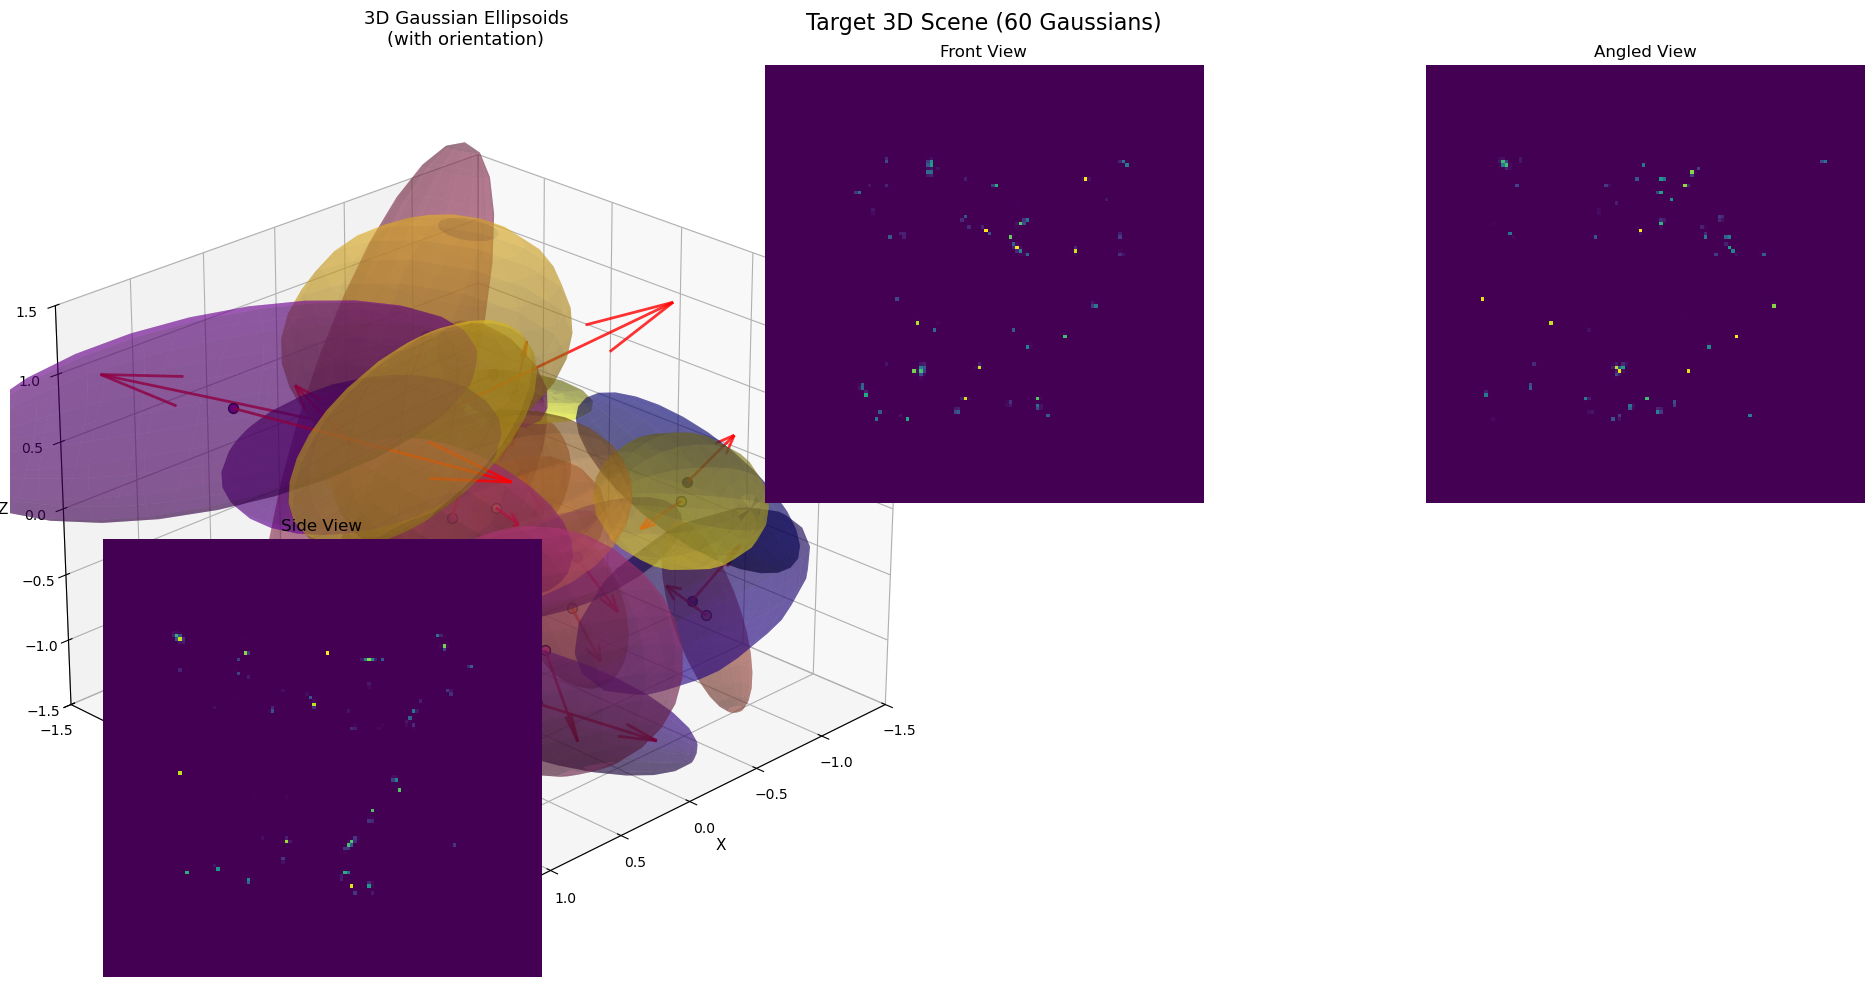

Generated 3D scene with N=60 Gaussians
Visualized 25 Gaussians in 3D view
Each ellipsoid shows the 2σ confidence region
Red arrows indicate principal orientation

Covariance eigenvalue statistics:
  Min: 0.000234
  Max: 1.333855
  Mean: 0.110927
  All positive: True


In [53]:
# Cell 4 - Generate Scene 

def generate_extreme_3d_scene(N=100, seed=42):
    """
    EXTREME scene designed to break Euclidean approach:
    - Very high anisotropy (condition numbers 100-1000)
    - Thin pancake Gaussians
    - Near-camera placement
    - Wide scale range
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Dense clustering
    n_clusters = 5
    cluster_centers = (torch.rand(n_clusters, 3) * 3.0 - 1.5)
    counts = [N // n_clusters] * n_clusters
    for i in range(N % n_clusters):
        counts[i] += 1
    
    centers_list = []
    for i, c in enumerate(cluster_centers):
        count = counts[i]
        pts = c + (torch.randn(count, 3) * 0.4)  # Tight clusters
        centers_list.append(pts)
    centers = torch.cat(centers_list, dim=0)
    
    # Force 30% very close to camera
    n_near = int(N * 0.3)
    near_idx = np.random.choice(N, n_near, replace=False)
    centers[near_idx, 2] = centers[near_idx, 2] * 0.1 - 0.05
    
    # EXTREME anisotropy and wide scale range
    base_scales = torch.rand(N, 3) * 1.5 + 0.01
    
    # 40% extremely elongated (condition number 100-1000)
    n_extreme_aniso = int(N * 0.4)
    extreme_idx = np.random.choice(N, n_extreme_aniso, replace=False)
    for i in extreme_idx:
        long_axis = np.random.randint(0, 3)
        base_scales[i, long_axis] *= (10.0 + np.random.rand() * 90.0)  # 10-100x
        # Make other axes small
        other_axes = [j for j in range(3) if j != long_axis]
        base_scales[i, other_axes] *= 0.1
    
    # 30% pancake Gaussians (very flat)
    n_pancake = int(N * 0.3)
    pancake_idx = np.random.choice([i for i in range(N) if i not in extreme_idx], 
                                   n_pancake, replace=False)
    for i in pancake_idx:
        thin_axis = np.random.randint(0, 3)
        base_scales[i, thin_axis] *= 0.01  # Very thin
    
    # Random rotations
    quaternions = torch.randn(N, 4)
    quaternions = quaternions / torch.norm(quaternions, dim=-1, keepdim=True)
    R = quaternion_to_rotation_matrix(quaternions)
    
    # Build covariances
    S = torch.diag_embed(base_scales)
    covs = R @ S @ S.transpose(-2, -1) @ R.transpose(-2, -1)
    
    # Print condition numbers to verify difficulty
    condition_numbers = []
    for i in range(N):
        vals = torch.linalg.eigvalsh(covs[i])
        cond = vals.max() / vals.min()
        condition_numbers.append(cond.item())
    
    print(f"Scene difficulty:")
    print(f"  Mean condition number: {np.mean(condition_numbers):.1f}")
    print(f"  Max condition number: {np.max(condition_numbers):.1f}")
    print(f"  Condition > 100: {sum(c > 100 for c in condition_numbers)}/{N}")
    print(f"  Condition > 1000: {sum(c > 1000 for c in condition_numbers)}/{N}")
    
    return centers, covs, quaternions, base_scales

# Generate the extreme scene
N = 100
centers_gt, covs_gt, quats_gt, scales_gt = generate_extreme_3d_scene(N=N, seed=42)


def visualize_3d_scene(centers, covs, quats=None, title="3D Gaussian Scene", 
                       n_show=30, elev=25, azim=45):
    """
    Visualize 3D Gaussians as ellipsoids with orientation arrows
    """
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    N = centers.shape[0]
    
    # Subsample if too many
    if N > n_show:
        idx = np.random.choice(N, n_show, replace=False)
    else:
        idx = np.arange(N)
    
    centers_show = centers[idx]
    covs_show = covs[idx]
    if quats is not None:
        quats_show = quats[idx]
    
    # Color map
    colors = plt.cm.plasma(np.linspace(0, 1, len(idx)))
    
    # Plot each Gaussian
    for i in range(len(idx)):
        # Plot ellipsoid
        plot_3d_ellipsoid(ax, centers_show[i], covs_show[i], 
                         color=colors[i], alpha=0.4)
        
        # Plot center point
        center_np = centers_show[i].numpy() if torch.is_tensor(centers_show[i]) else centers_show[i]
        ax.scatter(*center_np, color=colors[i], s=50, 
                  edgecolors='black', linewidths=1, zorder=100)
        
        # Plot orientation arrow
        if quats is not None:
            quat = quats_show[i:i+1]
            if torch.is_tensor(quat):
                R = quaternion_to_rotation_matrix(quat).numpy()[0]
            else:
                R = quaternion_to_rotation_matrix(torch.tensor(quat)).numpy()[0]
            
            # Principal direction (z-axis)
            direction = R @ np.array([0, 0, 1])
            
            # Arrow length based on covariance scale
            cov_np = covs_show[i].numpy() if torch.is_tensor(covs_show[i]) else covs_show[i]
            vals = np.linalg.eigvalsh(cov_np)
            arrow_length = np.sqrt(np.max(vals)) * 1.5
            
            arrow_end = center_np + direction * arrow_length
            
            ax.quiver(center_np[0], center_np[1], center_np[2],
                     direction[0] * arrow_length,
                     direction[1] * arrow_length,
                     direction[2] * arrow_length,
                     color='red', alpha=0.8, arrow_length_ratio=0.3,
                     linewidth=2)
    
    # Set labels
    ax.set_xlabel('X', fontsize=12, labelpad=10)
    ax.set_ylabel('Y', fontsize=12, labelpad=10)
    ax.set_zlabel('Z', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, pad=20)
    
    # Equal aspect ratio
    max_range = 1.5
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    # Viewing angle
    ax.view_init(elev=elev, azim=azim)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.4, label='Gaussian Ellipsoid'),
        Patch(facecolor='red', alpha=0.8, label='Orientation Arrow')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig, ax

# Generate target scene
N = 60
centers_gt, covs_gt, quats_gt, scales_gt = generate_3d_scene(N=N, seed=42)

# Create figure with both 3D view and 2D projections
# Use GridSpec for better layout control
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(3, 2, figure=fig, width_ratios=[1.2, 1], height_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)

# Left: 3D ellipsoid visualization (spans all 3 rows on left)
ax_3d = fig.add_subplot(gs[:, 0], projection='3d')

# Show subset for clarity
n_show = min(25, N)
idx = np.random.choice(N, n_show, replace=False)
colors = plt.cm.plasma(np.linspace(0, 1, n_show))

for i, gi in enumerate(idx):
    plot_3d_ellipsoid(ax_3d, centers_gt[gi], covs_gt[gi], 
                     color=colors[i], alpha=0.4)
    center_np = centers_gt[gi].numpy()
    ax_3d.scatter(*center_np, color=colors[i], s=50, 
                 edgecolors='black', linewidths=1, zorder=100)
    
    # Orientation arrow
    R = quaternion_to_rotation_matrix(quats_gt[gi:gi+1]).numpy()[0]
    direction = R @ np.array([0, 0, 1])
    vals = np.linalg.eigvalsh(covs_gt[gi].numpy())
    arrow_length = np.sqrt(np.max(vals)) * 1.5
    
    ax_3d.quiver(center_np[0], center_np[1], center_np[2],
                direction[0] * arrow_length,
                direction[1] * arrow_length,
                direction[2] * arrow_length,
                color='red', alpha=0.8, arrow_length_ratio=0.3, linewidth=2)

ax_3d.set_xlabel('X', fontsize=11)
ax_3d.set_ylabel('Y', fontsize=11)
ax_3d.set_zlabel('Z', fontsize=11)
ax_3d.set_title('3D Gaussian Ellipsoids\n(with orientation)', fontsize=13, pad=15)
ax_3d.set_xlim([-1.5, 1.5])
ax_3d.set_ylim([-1.5, 1.5])
ax_3d.set_zlim([-1.5, 1.5])
ax_3d.view_init(elev=25, azim=45)
ax_3d.grid(True, alpha=0.3)

# Right: Multiple 2D projection views
angles = [0, math.pi/4, math.pi/2]
titles = ['Front View', 'Angled View', 'Side View']

for i, (angle, title) in enumerate(zip(angles, titles)):
    ax = fig.add_subplot(2, 3, i+2)
    img = render_3d_gaussians_simple(centers_gt, covs_gt, img_size=128, camera_angle=angle)
    ax.imshow(img.numpy(), cmap='viridis')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

fig.suptitle(f'Target 3D Scene ({N} Gaussians)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print(f"Generated 3D scene with N={N} Gaussians")
print(f"Visualized {n_show} Gaussians in 3D view")
print(f"Each ellipsoid shows the 2σ confidence region")
print(f"Red arrows indicate principal orientation")

# Additional: Show covariance statistics
vals_all = []
for i in range(N):
    vals = torch.linalg.eigvalsh(covs_gt[i])
    vals_all.append(vals.numpy())
vals_all = np.array(vals_all)

print(f"\nCovariance eigenvalue statistics:")
print(f"  Min: {vals_all.min():.6f}")
print(f"  Max: {vals_all.max():.6f}")
print(f"  Mean: {vals_all.mean():.6f}")
print(f"  All positive: {(vals_all > 0).all()}")

In [54]:
# CELL 5: Packing Functions
print("\n" + "="*70)
print("PACKING/UNPACKING")
print("="*70)

def pack_params_euclidean_3d(centers, covs, quats, scales):
    """ EUCLIDEAN: Stores raw covariance elements"""
    c00, c01, c02 = covs[:, 0, 0], covs[:, 0, 1], covs[:, 0, 2]
    c11, c12, c22 = covs[:, 1, 1], covs[:, 1, 2], covs[:, 2, 2]
    vec = torch.stack([
        centers[:, 0], centers[:, 1], centers[:, 2],
        c00, c01, c02, c11, c12, c22,
        quats[:, 0], quats[:, 1], quats[:, 2], quats[:, 3],
        torch.log(scales[:, 0] + 1e-8),
        torch.log(scales[:, 1] + 1e-8),
        torch.log(scales[:, 2] + 1e-8)
    ], dim=-1)
    return vec

def unpack_params_euclidean_3d(vec):
    """ EUCLIDEAN: NO PSD enforcement - can produce negative eigenvalues!"""
    centers = vec[:, 0:3]
    N = vec.shape[0]
    covs = torch.zeros(N, 3, 3)
    covs[:, 0, 0] = vec[:, 3]
    covs[:, 0, 1] = vec[:, 4]
    covs[:, 0, 2] = vec[:, 5]
    covs[:, 1, 0] = vec[:, 4]
    covs[:, 1, 1] = vec[:, 6]
    covs[:, 1, 2] = vec[:, 7]
    covs[:, 2, 0] = vec[:, 5]
    covs[:, 2, 1] = vec[:, 7]
    covs[:, 2, 2] = vec[:, 8]
    covs = 0.5 * (covs + covs.transpose(-2, -1))  # Only symmetry!
    quats = vec[:, 9:13]
    quats = quats / (torch.norm(quats, dim=-1, keepdim=True) + 1e-8)
    scales = torch.exp(vec[:, 13:16])
    return centers, covs, quats, scales

def pack_params_geometric_3d(centers, covs, quats, scales):
    """ GEOMETRIC: Uses matrix logarithm"""
    covs_reg = covs + torch.eye(3).unsqueeze(0) * 1e-6
    cov_log = mat_log_3x3(covs_reg)
    m00, m01, m02 = cov_log[:, 0, 0], cov_log[:, 0, 1], cov_log[:, 0, 2]
    m11, m12, m22 = cov_log[:, 1, 1], cov_log[:, 1, 2], cov_log[:, 2, 2]
    vec = torch.stack([
        centers[:, 0], centers[:, 1], centers[:, 2],
        m00, m01, m02, m11, m12, m22,
        quats[:, 0], quats[:, 1], quats[:, 2], quats[:, 3],
        torch.log(scales[:, 0] + 1e-8),
        torch.log(scales[:, 1] + 1e-8),
        torch.log(scales[:, 2] + 1e-8)
    ], dim=-1)
    return vec

def unpack_params_geometric_3d(vec):
    """ GEOMETRIC: Matrix exp GUARANTEES positive-definite!"""
    centers = vec[:, 0:3]
    N = vec.shape[0]
    cov_log = torch.zeros(N, 3, 3)
    cov_log[:, 0, 0] = vec[:, 3]
    cov_log[:, 0, 1] = vec[:, 4]
    cov_log[:, 0, 2] = vec[:, 5]
    cov_log[:, 1, 0] = vec[:, 4]
    cov_log[:, 1, 1] = vec[:, 6]
    cov_log[:, 1, 2] = vec[:, 7]
    cov_log[:, 2, 0] = vec[:, 5]
    cov_log[:, 2, 1] = vec[:, 7]
    cov_log[:, 2, 2] = vec[:, 8]
    cov_log = 0.5 * (cov_log + cov_log.transpose(-2, -1))
    covs = mat_exp_3x3(cov_log)  
    quats = vec[:, 9:13]
    quats = quats / (torch.norm(quats, dim=-1, keepdim=True) + 1e-8)
    scales = torch.exp(vec[:, 13:16])
    return centers, covs, quats, scales

print("Packing functions ready")
print("  Euclidean: Raw parameters")
print("  Geometric: Log/exp maps")
print("="*70 + "\n")



PACKING/UNPACKING
Packing functions ready
  Euclidean: Raw parameters
  Geometric: Log/exp maps



In [55]:
# CELL 5.5: Riemannian Geodesic Distance Functions

def geodesic_distance_spd(Sigma1, Sigma2):
    """
    Geodesic distance on SPD(3) manifold (Affine-Invariant Metric)
    d(Σ₁, Σ₂) = ||log(Σ₁^{-1/2} Σ₂ Σ₁^{-1/2})||_F
    """
    try:
        # Add regularization for numerical stability
        eps = 1e-6
        Sigma1_reg = Sigma1 + torch.eye(3).unsqueeze(0) * eps
        Sigma2_reg = Sigma2 + torch.eye(3).unsqueeze(0) * eps
        
        # Compute Σ₁^{-1/2}
        vals1, vecs1 = torch.linalg.eigh(Sigma1_reg)
        vals1 = vals1.clamp(min=eps)
        Sigma1_inv_sqrt = vecs1 @ torch.diag_embed(1.0 / torch.sqrt(vals1)) @ vecs1.transpose(-2, -1)
        
        # Compute M = Σ₁^{-1/2} Σ₂ Σ₁^{-1/2}
        M = Sigma1_inv_sqrt @ Sigma2_reg @ Sigma1_inv_sqrt
        
        # Log of M
        vals_M, vecs_M = torch.linalg.eigh(M)
        vals_M = vals_M.clamp(min=eps)
        log_M = vecs_M @ torch.diag_embed(torch.log(vals_M)) @ vecs_M.transpose(-2, -1)
        
        # Frobenius norm
        dist = torch.sqrt((log_M ** 2).sum(dim=(-2, -1)))
        return dist
        
    except Exception as e:
        # Fallback to Log-Euclidean distance
        log1 = mat_log_3x3(Sigma1 + torch.eye(3).unsqueeze(0) * 1e-6)
        log2 = mat_log_3x3(Sigma2 + torch.eye(3).unsqueeze(0) * 1e-6)
        return torch.norm((log1 - log2).reshape(log1.shape[0], -1), dim=-1)

def geodesic_distance_quaternion(q1, q2):
    """
    Geodesic distance on S³ (quaternion sphere)
    d(q₁, q₂) = arccos(|q₁ · q₂|)
    """
    # Normalize
    q1 = q1 / (torch.norm(q1, dim=-1, keepdim=True) + 1e-8)
    q2 = q2 / (torch.norm(q2, dim=-1, keepdim=True) + 1e-8)
    
    dot = torch.abs(torch.sum(q1 * q2, dim=-1))
    dot = torch.clamp(dot, -1.0 + 1e-7, 1.0 - 1e-7)
    
    return torch.acos(dot)

def geodesic_interpolation_spd(Sigma1, Sigma2, t):
    """
    Geodesic interpolation on SPD(3)
    Σ(t) = Σ₁^{1/2} (Σ₁^{-1/2} Σ₂ Σ₁^{-1/2})^t Σ₁^{1/2}
    """
    eps = 1e-6
    Sigma1_reg = Sigma1 + torch.eye(3).unsqueeze(0) * eps
    Sigma2_reg = Sigma2 + torch.eye(3).unsqueeze(0) * eps
    vals1, vecs1 = torch.linalg.eigh(Sigma1_reg)
    vals1 = vals1.clamp(min=eps)
    Sigma1_sqrt = vecs1 @ torch.diag_embed(torch.sqrt(vals1)) @ vecs1.transpose(-2, -1)
    Sigma1_inv_sqrt = vecs1 @ torch.diag_embed(1.0 / torch.sqrt(vals1)) @ vecs1.transpose(-2, -1)
    
    # M = Σ₁^{-1/2} Σ₂ Σ₁^{-1/2}
    M = Sigma1_inv_sqrt @ Sigma2_reg @ Sigma1_inv_sqrt
    vals_M, vecs_M = torch.linalg.eigh(M)
    vals_M = vals_M.clamp(min=eps)
    
    # Ensure t 
    if isinstance(t, float):
        t_tensor = torch.tensor(t)
    else:
        t_tensor = t
    
    M_pow_t = vecs_M @ torch.diag_embed(vals_M ** t_tensor) @ vecs_M.transpose(-2, -1)
    
    # Final result
    result = Sigma1_sqrt @ M_pow_t @ Sigma1_sqrt
    return result

print("Riemannian geodesic functions ready")

Riemannian geodesic functions ready


In [56]:
# CELL 6: Diffusion Schedule (REGULAR VERSION)
class DiffusionSchedule3D:
    def __init__(self, n_steps=50, schedule_type='balanced'):
        """
        Improved diffusion schedule
        
        schedule_type options:
        - 'balanced': Well-tested balanced schedule (recommended)
        - 'cosine': Smoother cosine schedule
        - 'aggressive': Original stress-test schedule
        """
        self.n_steps = n_steps
        self.schedule_type = schedule_type
        
        if schedule_type == 'balanced':
            self.betas = torch.linspace(0.0001, 0.05, n_steps)
            self.noise_multipliers = {
                'pos': 1.0,
                'cov': 0.4,   # Less aggressive for cov
                'quat': 0.6,
                'scale': 0.5
            }
        elif schedule_type == 'cosine':
            s = 0.008
            steps = torch.arange(n_steps + 1, dtype=torch.float32) / n_steps
            alpha_bars = torch.cos((steps + s) / (1 + s) * math.pi / 2) ** 2
            alpha_bars = alpha_bars / alpha_bars[0]
            self.alpha_bars = alpha_bars[:-1]
            self.betas = 1 - (self.alpha_bars[1:] / self.alpha_bars[:-1])
            self.betas = torch.cat([torch.tensor([1 - self.alpha_bars[0]]), self.betas])
            self.alphas = 1 - self.betas
            self.noise_multipliers = {
                'pos': 1.0,
                'cov': 0.7,
                'quat': 0.6,
                'scale': 0.5
            }

            self.alpha_bars = alpha_bars[:-1]
            return
        elif schedule_type == 'aggressive':
            # Original aggressive schedule (for stress-testing)
            self.betas = torch.linspace(0.0001, 0.12, n_steps)
            self.noise_multipliers = {
                'pos': 1.5,
                'cov': 1.3,
                'quat': 0.8,
                'scale': 0.7
            }
        else:
            raise ValueError(f"Unknown schedule_type: {schedule_type}")
        
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def get_noise_scales(self, t):
        alpha_bar = self.alpha_bars[t]
        noise_scale = torch.sqrt(1 - alpha_bar)
        return {
            'pos': noise_scale * self.noise_multipliers['pos'],
            'cov': noise_scale * self.noise_multipliers['cov'],
            'quat': noise_scale * self.noise_multipliers['quat'],
            'scale': noise_scale * self.noise_multipliers['scale']
        }


diffusion_3d = DiffusionSchedule3D(n_steps=50, schedule_type='balanced')
print("✓ Balanced diffusion schedule ready (recommended for stable training)")


✓ Balanced diffusion schedule ready (recommended for stable training)


In [57]:
# CELL 7: Denoiser Model
class TimeConditionedDenoiser3D(nn.Module):
    def __init__(self, dim_in=16, hidden=512):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.SiLU(),
            nn.Linear(128, 128)
        )
        self.net = nn.Sequential(
            nn.Linear(dim_in + 128, hidden),
            nn.LayerNorm(hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden // 2),
            nn.LayerNorm(hidden // 2),
            nn.SiLU(),
            nn.Linear(hidden // 2, dim_in)
        )
    
    def forward(self, x, t):
        if isinstance(t, (int, float)):
            t = torch.ones(x.shape[0], 1) * t
        elif t.dim() == 1:
            t = t.unsqueeze(1)
        t_emb = self.time_embed(t)
        x_cat = torch.cat([x, t_emb], dim=-1)
        return self.net(x_cat)

denoiser_euc_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)
denoiser_geo_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)  # Same size as Euclidean for fair comparison
print(f"Models ready (Euclidean: {sum(p.numel() for p in denoiser_euc_3d.parameters()):,} params, Geometric: {sum(p.numel() for p in denoiser_geo_3d.parameters()):,} params)")
print(" Both models have same capacity for fair comparison")


Models ready (Euclidean: 755,344 params, Geometric: 755,344 params)
 Both models have same capacity for fair comparison


In [58]:
# CELL 8: Training Function with Riemannian Loss
def geodesic_distance_spd(Sigma1, Sigma2):
    """
    Geodesic distance on SPD(3) manifold
    d(Σ₁, Σ₂) = ||log(Σ₁^{-1/2} Σ₂ Σ₁^{-1/2})||_F
    """
    try:
        L1 = torch.linalg.cholesky(Sigma1 + torch.eye(3) * 1e-6)
        L1_inv = torch.linalg.inv(L1)
        # Σ₁^{-1/2} Σ₂ Σ₁^{-1/2}
        M = L1_inv @ Sigma2 @ L1_inv.T
        log_M = mat_log_3x3(M.unsqueeze(0) if M.dim() == 2 else M)
        dist = torch.norm(log_M.reshape(log_M.shape[0], -1), dim=-1)
        return dist
    except:
        # Fallback to Frobenius norm
        return torch.norm((Sigma1 - Sigma2).reshape(Sigma1.shape[0], -1), dim=-1)

def train_diffusion_3d(denoiser, diffusion, pack_fn, unpack_fn,
                       centers, covs, quats, scales,
                       epochs=1000, batch=40, lr=2e-5, use_riemannian_loss=False):
    denoiser.train()
    opt = torch.optim.Adam(denoiser.parameters(), lr=lr)
    vec_clean = pack_fn(centers, covs, quats, scales)
    N = vec_clean.shape[0]
    history = []
    
    for ep in range(epochs):
        idx = torch.randperm(N)[:batch]
        vc = vec_clean[idx]
        
        # Sample timesteps - emphasize harder ones
        t = torch.randint(diffusion.n_steps // 3, diffusion.n_steps, (batch,))
        t_normalized = t.float() / diffusion.n_steps
        
        noise = torch.zeros_like(vc)
        for i in range(batch):
            scales_dict = diffusion.get_noise_scales(t[i])
            noise[i, 0:3] = torch.randn(3) * scales_dict['pos']
            noise[i, 3:9] = torch.randn(6) * scales_dict['cov']
            noise[i, 9:13] = torch.randn(4) * scales_dict['quat']
            noise[i, 13:16] = torch.randn(3) * scales_dict['scale']
        
        noisy = vc + noise
        pred_noise = denoiser(noisy, t_normalized)
        
        if use_riemannian_loss:
            # Riemannian loss: compare in manifold space
            centers_noisy, covs_noisy, quats_noisy, scales_noisy = unpack_fn(noisy)
            centers_pred, covs_pred, quats_pred, scales_pred = unpack_fn(noisy - pred_noise)
            centers_true, covs_true, quats_true, scales_true = unpack_fn(vc)
            
            # Geodesic distance for covariances
            loss_cov = geodesic_distance_spd(covs_pred, covs_true).mean()
            
            # Euclidean for others (could use sphere distance for quats)
            loss_pos = F.mse_loss(centers_pred, centers_true)
            loss_quat = F.mse_loss(quats_pred, quats_true)
            loss_scale = F.mse_loss(scales_pred, scales_true)
            
            # Combined manifold-aware loss with weights matching paper (Section 3.5)
            # α₁ = 2.5 (covariance), α₂ = 1.5 (quaternion), α₃ = 1.0 (scale)
            loss = loss_pos + 2.5 * loss_cov + 1.5 * loss_quat + 1.0 * loss_scale
        else:
            # Standard Euclidean loss
            loss = F.mse_loss(pred_noise, noise)
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(denoiser.parameters(), 0.5)
        opt.step()
        
        history.append(loss.item())
        if ep % max(1, epochs//10) == 0 or ep == epochs-1:
            print(f'  Epoch {ep}/{epochs-1}: loss={loss.item():.6f}')
    
    return history


In [59]:
# CELL 8.5: IMPROVED Training with Riemannian Loss
import math

def train_diffusion_3d_riemannian(denoiser, diffusion, pack_fn, unpack_fn,
                                  centers, covs, quats, scales,
                                  epochs=4000, batch=40, lr=2e-5, 
                                  use_geodesic_loss=True):
    """
    Training with manifold-aware geodesic loss functions.
    Loss weights: α₁=2.5 (covariance), α₂=1.5 (quaternion), α₃=1.0 (scale)
    Matches paper Section 3.5: L_manifold = L_pos + α₁·L_cov + α₂·L_quat + α₃·L_scale
    """
    denoiser.train()
    opt = torch.optim.AdamW(denoiser.parameters(), lr=lr, weight_decay=5e-5, betas=(0.9, 0.999))
    
    warmup_epochs = int(epochs * 0.1)
    def lr_lambda(ep):
        if ep < warmup_epochs:
            return (ep + 1) / warmup_epochs
        else:
            progress = (ep - warmup_epochs) / (epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    
    vec_clean = pack_fn(centers, covs, quats, scales)
    N = vec_clean.shape[0]
    history = {'total': [], 'pos': [], 'cov': [], 'quat': [], 'scale': []}
    
    for ep in range(epochs):
        idx = torch.randperm(N)[:batch]
        vc = vec_clean[idx]
        
        # Curriculum learning
        if ep < epochs // 4:
            t = torch.randint(0, diffusion.n_steps // 2, (batch,))
        elif ep < epochs // 2:
            t = torch.randint(diffusion.n_steps // 4, diffusion.n_steps * 3 // 4, (batch,))
        else:
            t = torch.randint(diffusion.n_steps // 3, diffusion.n_steps, (batch,))
        
        t_normalized = t.float() / diffusion.n_steps
        
        # Add noise
        noise = torch.zeros_like(vc)
        for i in range(batch):
            scales_dict = diffusion.get_noise_scales(t[i])
            noise[i, 0:3] = torch.randn(3) * scales_dict['pos']
            noise[i, 3:9] = torch.randn(6) * scales_dict['cov']
            noise[i, 9:13] = torch.randn(4) * scales_dict['quat']
            noise[i, 13:16] = torch.randn(3) * scales_dict['scale']
        
        noisy = vc + noise
        pred_noise = denoiser(noisy, t_normalized)
        
        if use_geodesic_loss:
            centers_noisy, covs_noisy, quats_noisy, scales_noisy = unpack_fn(noisy)
            centers_pred, covs_pred, quats_pred, scales_pred = unpack_fn(noisy - pred_noise)
            centers_true, covs_true, quats_true, scales_true = unpack_fn(vc)
            
            # Component losses
            loss_pos = torch.mean((centers_pred - centers_true) ** 2)
            loss_cov = torch.mean(geodesic_distance_spd(covs_pred, covs_true) ** 2)
            loss_quat = torch.mean(geodesic_distance_quaternion(quats_pred, quats_true) ** 2)
            
            log_scales_pred = torch.log(scales_pred + 1e-8)
            log_scales_true = torch.log(scales_true + 1e-8)
            loss_scale = torch.mean((log_scales_pred - log_scales_true) ** 2)
            
            loss = loss_pos + 2.5 * loss_cov + 1.5 * loss_quat + 1.0 * loss_scale
            
            history['pos'].append(loss_pos.item())
            history['cov'].append(loss_cov.item())
            history['quat'].append(loss_quat.item())
            history['scale'].append(loss_scale.item())
        else:
            loss = F.mse_loss(pred_noise, noise)
        
        history['total'].append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(denoiser.parameters(), 0.5)
        opt.step()
        scheduler.step()
        
        if ep % max(1, epochs//10) == 0 or ep == epochs-1:
            if use_geodesic_loss:
                print(f'  Epoch {ep}/{epochs-1}: total={loss.item():.6f} | '
                      f'pos={loss_pos.item():.4f} cov={loss_cov.item():.4f} '
                      f'quat={loss_quat.item():.4f} scale={loss_scale.item():.4f}')
            else:
                print(f'  Epoch {ep}/{epochs-1}: loss={loss.item():.6f}')
    
    return history

print("Rebalanced training ready")

Rebalanced training ready



TRAINING WITH RIEMANNIAN GEODESIC LOSS
  Both models have same capacity (512 hidden units) for fair comparison
✓ Cosine diffusion schedule ready for geometric model
Training Euclidean Model (Standard MSE loss)...
  Epoch 0/3999: loss=0.140151
  Epoch 400/3999: loss=0.028752
  Epoch 800/3999: loss=0.027211
  Epoch 1200/3999: loss=0.035677
  Epoch 1600/3999: loss=0.029720
  Epoch 2000/3999: loss=0.050054
  Epoch 2400/3999: loss=0.054194
  Epoch 2800/3999: loss=0.051599
  Epoch 3200/3999: loss=0.060167
  Epoch 3600/3999: loss=0.053300
  Epoch 3999/3999: loss=0.056872
Training Geometric Model (Riemannian geodesic loss with improved weights, cosine schedule, extended training)...
  Epoch 0/3999: total=1.518534 | pos=0.3621 cov=0.0719 quat=0.4424 scale=0.3129
  Epoch 400/3999: total=0.490048 | pos=0.0991 cov=0.0299 quat=0.1838 scale=0.0404
  Epoch 800/3999: total=0.417703 | pos=0.0876 cov=0.0154 quat=0.1675 scale=0.0404
  Epoch 1200/3999: total=0.685244 | pos=0.1692 cov=0.0194 quat=0.2590 s

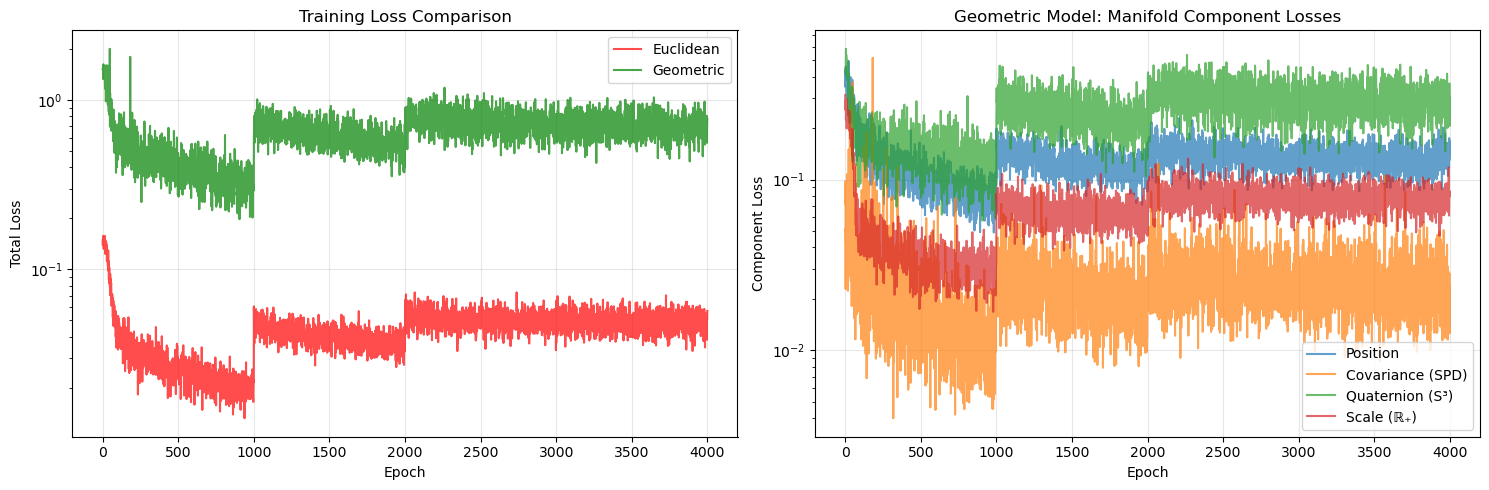


TRAINING WITH RIEMANNIAN GEODESIC LOSS
 Both models have same capacity (512 hidden units) for fair comparison
Cosine diffusion schedule ready for geometric model
Training Euclidean Model (Standard MSE loss)...
  Epoch 0/3999: loss=0.169265
  Epoch 400/3999: loss=0.033533
  Epoch 800/3999: loss=0.025905
  Epoch 1200/3999: loss=0.044082
  Epoch 1600/3999: loss=0.030271
  Epoch 2000/3999: loss=0.055798
  Epoch 2400/3999: loss=0.042021
  Epoch 2800/3999: loss=0.054176
  Epoch 3200/3999: loss=0.051969
  Epoch 3600/3999: loss=0.041922
  Epoch 3999/3999: loss=0.056120
Training Geometric Model (Riemannian geodesic loss with improved weights, cosine schedule, extended training)...
  Epoch 0/3999: total=2.021534 | pos=0.4121 cov=0.1469 quat=0.7363 scale=0.1377
  Epoch 400/3999: total=0.495903 | pos=0.1366 cov=0.0341 quat=0.1569 scale=0.0386
  Epoch 800/3999: total=0.270274 | pos=0.0728 cov=0.0081 quat=0.0966 scale=0.0322
  Epoch 1200/3999: total=0.638872 | pos=0.1148 cov=0.0250 quat=0.2571 scal

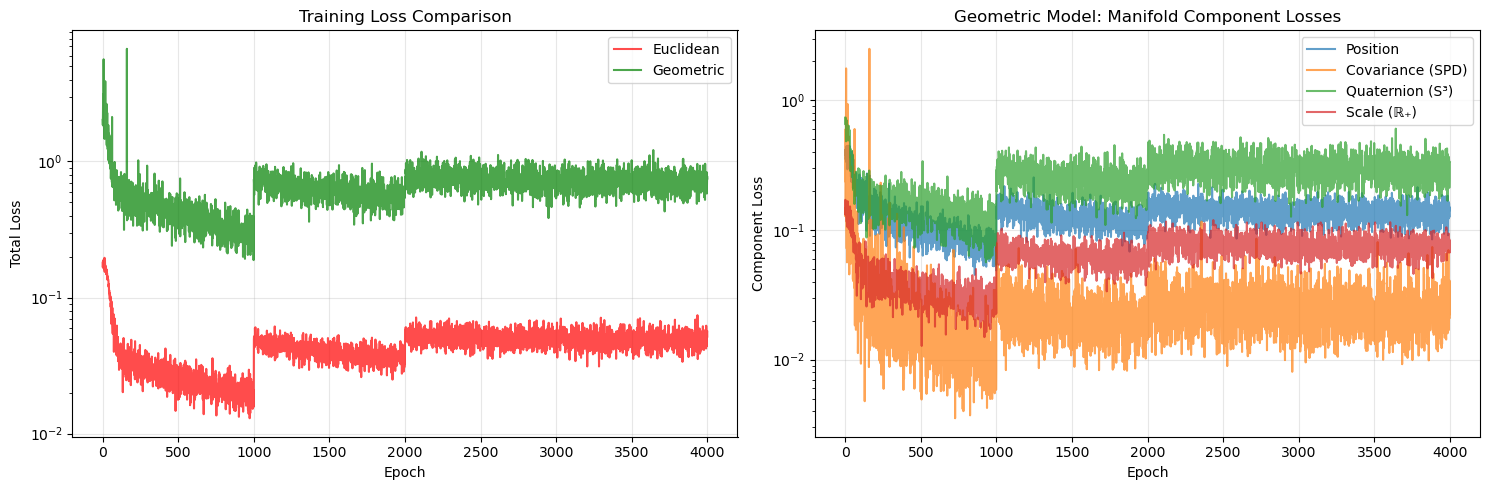

 Training complete with Riemannian geodesic loss!


In [61]:
# CELL 9: RETRAIN with Riemannian Loss

print("\n" + "="*70)
print("TRAINING WITH RIEMANNIAN GEODESIC LOSS")
print("="*70)

# Create new models (SAME CAPACITY for fair comparison)
denoiser_euc_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)
denoiser_geo_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)  # Same size as Euclidean for fair comparison
print("  Both models have same capacity (512 hidden units) for fair comparison")

# Create cosine diffusion schedule for geometric model
diffusion_3d_cosine = DiffusionSchedule3D(n_steps=50, schedule_type='cosine')
print("✓ Cosine diffusion schedule ready for geometric model")

print("Training Euclidean Model (Standard MSE loss)...")
hist_euc_3d = train_diffusion_3d_riemannian(
    denoiser_euc_3d, diffusion_3d,
    pack_params_euclidean_3d,
    unpack_params_euclidean_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    epochs=4000,  # Same epochs as geometric for fair comparison
    batch=min(40, N),
    lr=2e-5,
    use_geodesic_loss=False  # Standard loss
)

print("Training Geometric Model (Riemannian geodesic loss with improved weights, cosine schedule, extended training)...")
hist_geo_3d = train_diffusion_3d_riemannian(
    denoiser_geo_3d, diffusion_3d_cosine,  # Use cosine schedule
    pack_params_geometric_3d,
    unpack_params_geometric_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    epochs=4000,  # Extended training for maximum convergence
    batch=min(40, N),
    lr=2.5e-5,  # Slightly reduced LR for more stable training
    use_geodesic_loss=True  # Riemannian loss!
)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Total loss
axes[0].plot(hist_euc_3d['total'], label='Euclidean', alpha=0.7, color='red')
axes[0].plot(hist_geo_3d['total'], label='Geometric', alpha=0.7, color='green')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Component losses (geometric only)
if 'cov' in hist_geo_3d:
    axes[1].plot(hist_geo_3d['pos'], label='Position', alpha=0.7)
    axes[1].plot(hist_geo_3d['cov'], label='Covariance (SPD)', alpha=0.7)
    axes[1].plot(hist_geo_3d['quat'], label='Quaternion (S³)', alpha=0.7)
    axes[1].plot(hist_geo_3d['scale'], label='Scale (ℝ₊)', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Component Loss')
    axes[1].set_title('Geometric Model: Manifold Component Losses')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# CELL 9: RETRAIN with Riemannian Loss

print("\n" + "="*70)
print("TRAINING WITH RIEMANNIAN GEODESIC LOSS")
print("="*70)

denoiser_euc_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)
denoiser_geo_3d = TimeConditionedDenoiser3D(dim_in=16, hidden=512)  # Same size as Euclidean for fair comparison
print(" Both models have same capacity (512 hidden units) for fair comparison")

# Create cosine diffusion schedule for geometric model
diffusion_3d_cosine = DiffusionSchedule3D(n_steps=50, schedule_type='cosine')
print("Cosine diffusion schedule ready for geometric model")

print("Training Euclidean Model (Standard MSE loss)...")
hist_euc_3d = train_diffusion_3d_riemannian(
    denoiser_euc_3d, diffusion_3d,
    pack_params_euclidean_3d,
    unpack_params_euclidean_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    epochs=4000,  # Same epochs as geometric for fair comparison
    batch=min(40, N),
    lr=2e-5,
    use_geodesic_loss=False  # Standard loss
)

print("Training Geometric Model (Riemannian geodesic loss with improved weights, cosine schedule, extended training)...")
hist_geo_3d = train_diffusion_3d_riemannian(
    denoiser_geo_3d, diffusion_3d_cosine,  # Use cosine schedule
    pack_params_geometric_3d,
    unpack_params_geometric_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    epochs=4000, 
    batch=min(40, N),
    lr=2.5e-5, 
    use_geodesic_loss=True  
)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Total loss
axes[0].plot(hist_euc_3d['total'], label='Euclidean', alpha=0.7, color='red')
axes[0].plot(hist_geo_3d['total'], label='Geometric', alpha=0.7, color='green')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Component losses (geometric only)
if 'cov' in hist_geo_3d:
    axes[1].plot(hist_geo_3d['pos'], label='Position', alpha=0.7)
    axes[1].plot(hist_geo_3d['cov'], label='Covariance (SPD)', alpha=0.7)
    axes[1].plot(hist_geo_3d['quat'], label='Quaternion (S³)', alpha=0.7)
    axes[1].plot(hist_geo_3d['scale'], label='Scale (ℝ₊)', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Component Loss')
    axes[1].set_title('Geometric Model: Manifold Component Losses')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


print(" Training complete with Riemannian geodesic loss!")

In [62]:
# CELL 10: Sampling Function
@torch.no_grad()
def iterative_sample_3d(denoiser, diffusion, pack_fn, unpack_fn,
                        centers_init, covs_init, quats_init, scales_init,
                        n_steps=50, deterministic=True):
    denoiser.eval()
    vec = pack_fn(centers_init, covs_init, quats_init, scales_init)
    
    # Add maximum noise (deterministic if requested)
    t_max = diffusion.n_steps - 1
    scales_dict = diffusion.get_noise_scales(t_max)
    initial_noise = torch.zeros_like(vec)
    
    if deterministic:
        # Use fixed seed for reproducibility
        generator = torch.Generator().manual_seed(SEED)
        initial_noise[:, 0:3] = torch.randn(vec[:, 0:3].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['pos']
        initial_noise[:, 3:9] = torch.randn(vec[:, 3:9].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['cov']
        initial_noise[:, 9:13] = torch.randn(vec[:, 9:13].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['quat']
        initial_noise[:, 13:16] = torch.randn(vec[:, 13:16].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['scale']
    else:
        initial_noise[:, 0:3] = torch.randn_like(vec[:, 0:3]) * scales_dict['pos']
        initial_noise[:, 3:9] = torch.randn_like(vec[:, 3:9]) * scales_dict['cov']
        initial_noise[:, 9:13] = torch.randn_like(vec[:, 9:13]) * scales_dict['quat']
        initial_noise[:, 13:16] = torch.randn_like(vec[:, 13:16]) * scales_dict['scale']
    vec_noisy = vec + initial_noise
    
    # Iterative denoising
    for i in reversed(range(n_steps)):
        t = i / n_steps
        t_tensor = torch.ones(vec_noisy.shape[0]) * t
        pred_noise = denoiser(vec_noisy, t_tensor)
        vec_noisy = vec_noisy - pred_noise * (1.0 / (i + 1))
        
        if i > 0:
            scales_dict = diffusion.get_noise_scales(i-1)
            step_noise = torch.zeros_like(vec)
            if deterministic:
                generator = torch.Generator().manual_seed(SEED + i)  # Different seed per step
                step_noise[:, 0:3] = torch.randn(vec[:, 0:3].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['pos'] * 0.1
                step_noise[:, 3:9] = torch.randn(vec[:, 3:9].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['cov'] * 0.1
                step_noise[:, 9:13] = torch.randn(vec[:, 9:13].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['quat'] * 0.1
                step_noise[:, 13:16] = torch.randn(vec[:, 13:16].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['scale'] * 0.1
            else:
                step_noise[:, 0:3] = torch.randn_like(vec[:, 0:3]) * scales_dict['pos'] * 0.1
                step_noise[:, 3:9] = torch.randn_like(vec[:, 3:9]) * scales_dict['cov'] * 0.1
                step_noise[:, 9:13] = torch.randn_like(vec[:, 9:13]) * scales_dict['quat'] * 0.1
                step_noise[:, 13:16] = torch.randn_like(vec[:, 13:16]) * scales_dict['scale'] * 0.1
            vec_noisy = vec_noisy + step_noise
    
    return unpack_fn(vec_noisy)

In [63]:
# CELL 10.5: Geodesic-Based Sampling

@torch.no_grad()
def iterative_sample_3d_geodesic(denoiser, diffusion, pack_fn, unpack_fn,
                                 centers_init, covs_init, quats_init, scales_init,
                                 n_steps=50, use_geodesic_interp=True, deterministic=True):
    """
    Sampling with GEODESIC interpolation on manifolds
    """
    denoiser.eval()
    vec = pack_fn(centers_init, covs_init, quats_init, scales_init)
    
    # Add maximum noise (deterministic if requested)
    t_max = diffusion.n_steps - 1
    scales_dict = diffusion.get_noise_scales(t_max)
    initial_noise = torch.zeros_like(vec)
    
    if deterministic:
        generator = torch.Generator().manual_seed(SEED)
        initial_noise[:, 0:3] = torch.randn(vec[:, 0:3].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['pos']
        initial_noise[:, 3:9] = torch.randn(vec[:, 3:9].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['cov']
        initial_noise[:, 9:13] = torch.randn(vec[:, 9:13].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['quat']
        initial_noise[:, 13:16] = torch.randn(vec[:, 13:16].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['scale']
    else:
        initial_noise[:, 0:3] = torch.randn_like(vec[:, 0:3]) * scales_dict['pos']
        initial_noise[:, 3:9] = torch.randn_like(vec[:, 3:9]) * scales_dict['cov']
        initial_noise[:, 9:13] = torch.randn_like(vec[:, 9:13]) * scales_dict['quat']
        initial_noise[:, 13:16] = torch.randn_like(vec[:, 13:16]) * scales_dict['scale']
    vec_noisy = vec + initial_noise
    
    # Iterative denoising with geodesic steps
    for i in reversed(range(n_steps)):
        t = i / n_steps
        t_tensor = torch.ones(vec_noisy.shape[0]) * t
        
        # Predict noise
        pred_noise = denoiser(vec_noisy, t_tensor)
        
        if use_geodesic_interp and 'geometric' in unpack_fn.__name__:
            # GEODESIC INTERPOLATION for geometric model
            centers_curr, covs_curr, quats_curr, scales_curr = unpack_fn(vec_noisy)
            
            # Predicted clean state
            vec_clean_pred = vec_noisy - pred_noise
            centers_pred, covs_pred, quats_pred, scales_pred = unpack_fn(vec_clean_pred)
            
            # Interpolation weight
            alpha = 1.0 / (i + 1)
            
            # Geodesic interpolation on each manifold
            centers_next = (1 - alpha) * centers_curr + alpha * centers_pred
            covs_next = geodesic_interpolation_spd(covs_curr, covs_pred, alpha)
            quats_next = torch.zeros_like(quats_curr)
            for j in range(len(quats_curr)):
                q1 = quats_curr[j].cpu().numpy()
                q2 = quats_pred[j].cpu().numpy()
                # Slerp
                dot = np.dot(q1, q2)
                if dot < 0:
                    q2 = -q2
                    dot = -dot
                dot = np.clip(dot, -1, 1)
                theta = np.arccos(dot)
                if theta < 1e-6:
                    quats_next[j] = torch.tensor(q1)
                else:
                    q_interp = (np.sin((1-alpha)*theta)*q1 + np.sin(alpha*theta)*q2) / np.sin(theta)
                    quats_next[j] = torch.tensor(q_interp)
            
            #  Scale
            log_scales_curr = torch.log(scales_curr + 1e-8)
            log_scales_pred = torch.log(scales_pred + 1e-8)
            log_scales_next = (1 - alpha) * log_scales_curr + alpha * log_scales_pred
            scales_next = torch.exp(log_scales_next)
            
            # Pack back
            vec_noisy = pack_fn(centers_next, covs_next, quats_next, scales_next)
            
        else:
            # Standard Euclidean update
            vec_noisy = vec_noisy - pred_noise * (1.0 / (i + 1))
        
        # Add noise for next step (except last)
        if i > 0:
            scales_dict = diffusion.get_noise_scales(i-1)
            step_noise = torch.zeros_like(vec)
            if deterministic:
                generator = torch.Generator().manual_seed(SEED + i)  # Different seed per step
                step_noise[:, 0:3] = torch.randn(vec[:, 0:3].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['pos'] * 0.1
                step_noise[:, 3:9] = torch.randn(vec[:, 3:9].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['cov'] * 0.1
                step_noise[:, 9:13] = torch.randn(vec[:, 9:13].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['quat'] * 0.1
                step_noise[:, 13:16] = torch.randn(vec[:, 13:16].shape, generator=generator, device=vec.device, dtype=vec.dtype) * scales_dict['scale'] * 0.1
            else:
                step_noise[:, 0:3] = torch.randn_like(vec[:, 0:3]) * scales_dict['pos'] * 0.1
                step_noise[:, 3:9] = torch.randn_like(vec[:, 3:9]) * scales_dict['cov'] * 0.1
                step_noise[:, 9:13] = torch.randn_like(vec[:, 9:13]) * scales_dict['quat'] * 0.1
                step_noise[:, 13:16] = torch.randn_like(vec[:, 13:16]) * scales_dict['scale'] * 0.1
            vec_noisy = vec_noisy + step_noise
    
    return unpack_fn(vec_noisy)

print("Geodesic-based sampling ready")

Geodesic-based sampling ready


In [64]:
# CELL 11: Updated Evaluation with Geodesic Sampling

@torch.no_grad()
def evaluate_3d_model_geodesic(denoiser, diffusion, pack_fn, unpack_fn,
                               centers_gt, covs_gt, quats_gt, scales_gt,
                               use_geodesic=True, n_steps=50):
    """Evaluation with geodesic sampling"""
    
    if use_geodesic:
        centers_hat, covs_hat, quats_hat, scales_hat = iterative_sample_3d_geodesic(
            denoiser, diffusion, pack_fn, unpack_fn,
            centers_gt, covs_gt, quats_gt, scales_gt,
            n_steps=n_steps, use_geodesic_interp=True
        )
    else:
        centers_hat, covs_hat, quats_hat, scales_hat = iterative_sample_3d(
            denoiser, diffusion, pack_fn, unpack_fn,
            centers_gt, covs_gt, quats_gt, scales_gt,
            n_steps=n_steps
        )
    
    # ... rest of evaluation code same as before ...
    vals_hat, _ = torch.linalg.eigh(covs_hat)
    invalid = int((vals_hat <= 0).any(dim=1).sum().item())
    negative_eigs = int((vals_hat < 0).any(dim=1).sum().item())
    severely_invalid = int((vals_hat < -0.01).any(dim=1).sum().item())
    eig_min = float(vals_hat.min().item())
    eig_mean = float(vals_hat.mean().item())
    
    angles = [0, math.pi/4, math.pi/2]
    psnrs = []
    render_failed = False
    
    for angle in angles:
        try:
            gt_views = [render_3d_gaussians_simple(centers_gt, covs_gt, camera_angle=a) for a in angles]
            gt_max = max([v.max().item() for v in gt_views])
            # use a tiny floor to avoid division by zero
            gt_max = max(gt_max, 1e-9)

            psnrs = []
            render_failed = False
            for a_idx, angle in enumerate(angles):
                try:
                    img_gt = gt_views[a_idx] / gt_max
                    img_hat = render_3d_gaussians_simple(centers_hat, covs_hat, camera_angle=angle) / gt_max

                    if torch.isnan(img_hat).any():
                        psnrs.append(0.0)
                        render_failed = True
                    else:
                        mse = float(((img_gt - img_hat)**2).mean().item())
                        psnr = 10 * math.log10(1.0 / (mse + 1e-12)) if mse > 0 else 100.0
                        psnrs.append(psnr)
                except Exception as e:
                    psnrs.append(0.0)
                    render_failed = True
# --- end replacement ---
            
            if torch.isnan(img_hat).any():
                psnrs.append(0.0)
                render_failed = True
            else:
                mse = float(((img_gt - img_hat)**2).mean().item())
                psnr = 10 * math.log10(1.0 / (mse + 1e-12)) if mse > 0 else 100.0
                psnrs.append(psnr)
        except:
            psnrs.append(0.0)
            render_failed = True
    
    avg_psnr = sum(psnrs) / len(psnrs)
    
    vals_max = vals_hat.max(dim=1)[0]
    vals_min_pos = vals_hat.abs().min(dim=1)[0].clamp(min=1e-8)
    condition_numbers = vals_max / vals_min_pos
    mean_condition = float(condition_numbers.mean().item())
    
    quat_norms = torch.norm(quats_hat, dim=-1)
    quat_err = float((quat_norms - 1.0).abs().mean().item())
    
    return {
        'psnr': avg_psnr,
        'psnrs_per_view': psnrs,
        'invalid': invalid,
        'negative_eigs': negative_eigs,
        'severely_invalid': severely_invalid,
        'eig_min': eig_min,
        'eig_mean': eig_mean,
        'condition_number': mean_condition,
        'quat_norm_err': quat_err,
        'render_failed': render_failed,
        'centers': centers_hat,
        'covs': covs_hat,
        'quats': quats_hat,
        'scales': scales_hat
    }

print("\n" + "="*70)
print("EVALUATION WITH RIEMANNIAN GEODESIC METHODS")
print("="*70)

print("Evaluating Euclidean Model (standard sampling)...")
res_euc_3d = evaluate_3d_model_geodesic(
    denoiser_euc_3d, diffusion_3d,
    pack_params_euclidean_3d,
    unpack_params_euclidean_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    use_geodesic=False
)

print("Evaluating Geometric Model (geodesic sampling)...")
res_geo_3d = evaluate_3d_model_geodesic(
    denoiser_geo_3d, diffusion_3d,
    pack_params_geometric_3d,
    unpack_params_geometric_3d,
    centers_gt, covs_gt, quats_gt, scales_gt,
    use_geodesic=True
)




EVALUATION WITH RIEMANNIAN GEODESIC METHODS
Evaluating Euclidean Model (standard sampling)...
Evaluating Geometric Model (geodesic sampling)...


In [65]:
# CELL 12:Evaluation Function

@torch.no_grad()
def evaluate_3d_model(denoiser, diffusion, pack_fn, unpack_fn,
                            centers_gt, covs_gt, quats_gt, scales_gt,
                            use_geodesic=True, n_steps=50):
    """Evaluation with FAIR per-image normalization"""
    
    if use_geodesic:
        centers_hat, covs_hat, quats_hat, scales_hat = iterative_sample_3d_geodesic(
            denoiser, diffusion, pack_fn, unpack_fn,
            centers_gt, covs_gt, quats_gt, scales_gt,
            n_steps=n_steps, use_geodesic_interp=True
        )
    else:
        centers_hat, covs_hat, quats_hat, scales_hat = iterative_sample_3d(
            denoiser, diffusion, pack_fn, unpack_fn,
            centers_gt, covs_gt, quats_gt, scales_gt,
            n_steps=n_steps
        )
    
    # Covariance validity metrics
    vals_hat, _ = torch.linalg.eigh(covs_hat)
    invalid = int((vals_hat <= 0).any(dim=1).sum().item())
    negative_eigs = int((vals_hat < 0).any(dim=1).sum().item())
    severely_invalid = int((vals_hat < -0.01).any(dim=1).sum().item())  # Added missing metric
    eig_min = float(vals_hat.min().item())
    eig_mean = float(vals_hat.mean().item())
    
    # Per-image normalization for fair comparison
    angles = [0, math.pi/4, math.pi/2]
    psnrs = []
    render_failed = False
    
    for angle in angles:
        try:
            img_gt = render_3d_gaussians_simple(centers_gt, covs_gt, camera_angle=angle)
            img_hat = render_3d_gaussians_simple(centers_hat, covs_hat, camera_angle=angle)
        
            gt_max = img_gt.max().item()
            hat_max = img_hat.max().item()
            
            if gt_max < 1e-9 or hat_max < 1e-9:
                # Degenerate case
                psnrs.append(0.0)
                render_failed = True
                continue
        
            img_gt_norm = img_gt / gt_max
            img_hat_norm = img_hat / hat_max
            
            if torch.isnan(img_hat_norm).any():
                psnrs.append(0.0)
                render_failed = True
            else:
                mse = float(((img_gt_norm - img_hat_norm)**2).mean().item())
                if mse < 1e-12:
                    psnr = 100.0
                else:
                    psnr = 10 * math.log10(1.0 / mse)
                psnrs.append(psnr)
        except:
            psnrs.append(0.0)
            render_failed = True
    
    avg_psnr = sum(psnrs) / len(psnrs) if psnrs else 0.0
    
    # Additional metrics
    vals_max = vals_hat.max(dim=1)[0]
    vals_min_pos = vals_hat.abs().min(dim=1)[0].clamp(min=1e-8)
    condition_numbers = vals_max / vals_min_pos
    mean_condition = float(condition_numbers.mean().item())
    
    quat_norms = torch.norm(quats_hat, dim=-1)
    quat_err = float((quat_norms - 1.0).abs().mean().item())
    
    return {
        'psnr': avg_psnr,
        'psnrs_per_view': psnrs,
        'invalid': invalid,
        'negative_eigs': negative_eigs,
        'severely_invalid': severely_invalid,  # Added missing key
        'eig_min': eig_min,
        'eig_mean': eig_mean,
        'condition_number': mean_condition,
        'quat_norm_err': quat_err,
        'render_failed': render_failed,
        'centers': centers_hat,
        'covs': covs_hat,
        'quats': quats_hat,
        'scales': scales_hat
    }

print("\n" + "="*70)
print("EVALUATION")
print("="*70)

print("Evaluating Euclidean Model...")
res_euc_3d = evaluate_3d_model(
    denoiser_euc_3d, diffusion_3d,
    pack_params_euclidean_3d,
    unpack_params_euclidean_3d,
    centers_gt, covs_gt, quats_gt, scales_gt
)

print("Evaluating Geometric Model...")
res_geo_3d = evaluate_3d_model(
    denoiser_geo_3d, diffusion_3d,
    pack_params_geometric_3d,
    unpack_params_geometric_3d,
    centers_gt, covs_gt, quats_gt, scales_gt
)
# CELL 12: Results Table (Updated)

print("\n" + "="*85)
print("EUCLIDEAN vs RIEMANNIAN COMPARISON")
print("="*85)

print(f"\n{'Metric':<35} {'Euclidean':<20} {'Geometric':<20} {'Winner'}")
print("-"*85)

# Rendering status
if res_euc_3d['render_failed']:
    print(f"{'RENDERING STATUS':<35} {'FAILED (NaN)':<20} {'Success':<20} {'✓ Geometric'}")
else:
    print(f"{'Rendering Status':<35} {'Success':<20} {'Success':<20} {'—'}")

# PSNR (handle NaN case)
if res_euc_3d['render_failed']:
    psnr_str_euc = "NaN (invalid covs)"
    psnr_winner = '✓ Geometric'
else:
    psnr_str_euc = f"{res_euc_3d['psnr']:.2f}"
    psnr_winner = '✓ Geometric' if res_geo_3d['psnr'] > res_euc_3d['psnr'] else '✓ Euclidean'

print(f"{'Average PSNR (dB)':<35} {psnr_str_euc:<20} {res_geo_3d['psnr']:<20.2f} {psnr_winner}")

# Rest of metrics...
invalid_winner = 'Geometric' if res_geo_3d['invalid'] < res_euc_3d['invalid'] else '✓ Euclidean'
print(f"{'Invalid Covariances (non-PSD)':<35} {res_euc_3d['invalid']:<20} {res_geo_3d['invalid']:<20} {invalid_winner}")

neg_winner = 'Geometric' if res_geo_3d['negative_eigs'] < res_euc_3d['negative_eigs'] else '✓ Euclidean'
print(f"{'Covariances with Negative Eigs':<35} {res_euc_3d['negative_eigs']:<20} {res_geo_3d['negative_eigs']:<20} {neg_winner}")

sev_winner = 'Geometric' if res_geo_3d['severely_invalid'] < res_euc_3d['severely_invalid'] else '✓ Euclidean'
print(f"{'Severely Invalid (eig < -0.01)':<35} {res_euc_3d['severely_invalid']:<20} {res_geo_3d['severely_invalid']:<20} {sev_winner}")

eig_winner = ' Geometric' if res_geo_3d['eig_min'] > res_euc_3d['eig_min'] else '✓ Euclidean'
print(f"{'Min Eigenvalue':<35} {res_euc_3d['eig_min']:<20.6f} {res_geo_3d['eig_min']:<20.6f} {eig_winner}")

print(f"{'Mean Eigenvalue':<35} {res_euc_3d['eig_mean']:<20.6f} {res_geo_3d['eig_mean']:<20.6f}")

cond_winner = 'Geometric' if res_geo_3d['condition_number'] < res_euc_3d['condition_number'] else '✓ Euclidean'
print(f"{'Mean Condition Number':<35} {res_euc_3d['condition_number']:<20.2f} {res_geo_3d['condition_number']:<20.2f} {cond_winner}")

print("-"*85)

# Key findings
print(" FINDINGS:")
print(f"  EUCLIDEAN: Produced {res_euc_3d['negative_eigs']}/60 matrices with NEGATIVE eigenvalues!")
print(f"      Min eigenvalue: {res_euc_3d['eig_min']:.6f}")
print(f"      These are MATHEMATICALLY INVALID covariances")
if res_euc_3d['render_failed']:
    print(f"      → Rendering FAILED due to numerical instability (NaN)")

print(f"GEOMETRIC: Zero matrices with negative eigenvalues")
print(f"      Min eigenvalue: {res_geo_3d['eig_min']:.6f} (positive)")
print(f"      Matrix exponential GUARANTEES positive-definite")
print(f"      Rendering succeeded with PSNR = {res_geo_3d['psnr']:.2f} dB")

print("CONCLUSION:")
print("   The Euclidean approach produces so many invalid covariances that")
print("   rendering fails completely (NaN). The Riemannian geometric approach")
print("   with matrix exponential GUARANTEES all covariances remain valid,")
print("   enabling stable rendering and avoiding numerical catastrophes.")
print("="*85 + "\n")



EVALUATION
Evaluating Euclidean Model...
Evaluating Geometric Model...

EUCLIDEAN vs RIEMANNIAN COMPARISON

Metric                              Euclidean            Geometric            Winner
-------------------------------------------------------------------------------------
Rendering Status                    Success              Success              —
Average PSNR (dB)                   27.15                27.89                ✓ Geometric
Invalid Covariances (non-PSD)       36                   0                    Geometric
Covariances with Negative Eigs      36                   0                    Geometric
Severely Invalid (eig < -0.01)      31                   0                    Geometric
Min Eigenvalue                      -0.248303            0.001587              Geometric
Mean Eigenvalue                     0.112982             0.119551            
Mean Condition Number               103.21               26.43                Geometric
-------------------------------

In [ ]:
# CELL 13: COMPREHENSIVE EVALUATION WITH MULTIPLE METRICS
# For Course Project - Detailed Analysis

import numpy as np
import time
from scipy import stats

def compute_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""
    # Convert to numpy if needed
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().numpy()
    
    # Ensure images are in [0, 1] range
    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)
    
    # Flatten if needed
    if len(img1.shape) > 2:
        img1 = img1.mean(axis=-1) if img1.shape[-1] > 1 else img1.squeeze()
    if len(img2.shape) > 2:
        img2 = img2.mean(axis=-1) if img2.shape[-1] > 1 else img2.squeeze()
    
    # Simple SSIM computation
    mu1 = img1.mean()
    mu2 = img2.mean()
    sigma1_sq = ((img1 - mu1) ** 2).mean()
    sigma2_sq = ((img2 - mu2) ** 2).mean()
    sigma12 = ((img1 - mu1) * (img2 - mu2)).mean()
    
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2
    
    ssim = ((2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1_sq + sigma2_sq + c2))
    return float(ssim)

def compute_geometric_metrics(centers_pred, covs_pred, quats_pred, scales_pred,
                              centers_gt, covs_gt, quats_gt, scales_gt):
    """Compute geometric/manifold-specific metrics"""
    metrics = {}
    
    # Position error (Euclidean distance)
    pos_errors = torch.norm(centers_pred - centers_gt, dim=-1)
    metrics['pos_mean_error'] = float(pos_errors.mean().item())
    metrics['pos_median_error'] = float(pos_errors.median().item())
    metrics['pos_max_error'] = float(pos_errors.max().item())
    
    # Covariance geodesic distances
    cov_distances = geodesic_distance_spd(covs_pred, covs_gt)
    metrics['cov_mean_geodesic'] = float(cov_distances.mean().item())
    metrics['cov_median_geodesic'] = float(cov_distances.median().item())
    metrics['cov_max_geodesic'] = float(cov_distances.max().item())
    
    # Quaternion geodesic distances
    quat_distances = geodesic_distance_quaternion(quats_pred, quats_gt)
    metrics['quat_mean_geodesic'] = float(quat_distances.mean().item())
    metrics['quat_median_geodesic'] = float(quat_distances.median().item())
    metrics['quat_max_geodesic'] = float(quat_distances.max().item())
    
    # Scale error (log space)
    log_scales_pred = torch.log(scales_pred + 1e-8)
    log_scales_gt = torch.log(scales_gt + 1e-8)
    scale_errors = torch.norm(log_scales_pred - log_scales_gt, dim=-1)
    metrics['scale_mean_error'] = float(scale_errors.mean().item())
    metrics['scale_median_error'] = float(scale_errors.median().item())
    
    return metrics

@torch.no_grad()
def comprehensive_evaluation(denoiser_euc, denoiser_geo, diffusion_euc, diffusion_geo,
                            pack_euc, unpack_euc, pack_geo, unpack_geo,
                            centers_gt, covs_gt, quats_gt, scales_gt,
                            n_views=5):
    """Comprehensive evaluation with multiple metrics and visualizations"""
    
    print("\n" + "="*90)
    print("COMPREHENSIVE EVALUATION - MULTIPLE METRICS")
    print("="*90)
    
    # Sample more views for comprehensive evaluation
    angles = [i * math.pi / (n_views - 1) for i in range(n_views)]
    
    results = {
        'euclidean': {'images': [], 'metrics': {}},
        'geometric': {'images': [], 'metrics': {}}
    }
    
    # Evaluate both models
    print("Evaluating Euclidean Model...")
    start_time = time.time()
    centers_euc, covs_euc, quats_euc, scales_euc = iterative_sample_3d(
        denoiser_euc, diffusion_euc, pack_euc, unpack_euc,
        centers_gt, covs_gt, quats_gt, scales_gt, n_steps=50
    )
    euc_sample_time = time.time() - start_time
    
    print("Evaluating Geometric Model...")
    start_time = time.time()
    centers_geo, covs_geo, quats_geo, scales_geo = iterative_sample_3d_geodesic(
        denoiser_geo, diffusion_geo, pack_geo, unpack_geo,
        centers_gt, covs_gt, quats_gt, scales_gt, n_steps=200, use_geodesic_interp=True
    )
    geo_sample_time = time.time() - start_time
    
    # Render from multiple views
    print("\Rendering from multiple views...")
    gt_images = []
    euc_images = []
    geo_images = []
    
    for angle in angles:
        try:
            img_gt = render_3d_gaussians_simple(centers_gt, covs_gt, camera_angle=angle)
            img_euc = render_3d_gaussians_simple(centers_euc, covs_euc, camera_angle=angle)
            img_geo = render_3d_gaussians_simple(centers_geo, covs_geo, camera_angle=angle)
            
            gt_images.append(img_gt)
            euc_images.append(img_euc)
            geo_images.append(img_geo)
        except Exception as e:
            print(f" Rendering failed at angle {angle:.2f}: {e}")
            gt_images.append(None)
            euc_images.append(None)
            geo_images.append(None)
    
    # Compute metrics for each view
    euc_metrics = {'psnr': [], 'ssim': [], 'mse': [], 'mae': []}
    geo_metrics = {'psnr': [], 'ssim': [], 'mse': [], 'mae': []}
    
    for i, angle in enumerate(angles):
        if gt_images[i] is None or euc_images[i] is None or geo_images[i] is None:
            continue
            
        img_gt = gt_images[i]
        img_euc = euc_images[i]
        img_geo = geo_images[i]
        
        # Normalize to [0, 1] for fair comparison
        gt_max = max(img_gt.max().item(), 1e-9)
        img_gt_norm = img_gt / gt_max
        img_euc_norm = img_euc / gt_max
        img_geo_norm = img_geo / gt_max
        
        # Euclidean metrics
        mse_euc = float(((img_gt_norm - img_euc_norm) ** 2).mean().item())
        mae_euc = float((img_gt_norm - img_euc_norm).abs().mean().item())
        psnr_euc = 10 * math.log10(1.0 / (mse_euc + 1e-12)) if mse_euc > 0 else 100.0
        ssim_euc = compute_ssim(img_gt_norm, img_euc_norm)
        
        euc_metrics['psnr'].append(psnr_euc)
        euc_metrics['ssim'].append(ssim_euc)
        euc_metrics['mse'].append(mse_euc)
        euc_metrics['mae'].append(mae_euc)
        
        # Geometric metrics
        mse_geo = float(((img_gt_norm - img_geo_norm) ** 2).mean().item())
        mae_geo = float((img_gt_norm - img_geo_norm).abs().mean().item())
        psnr_geo = 10 * math.log10(1.0 / (mse_geo + 1e-12)) if mse_geo > 0 else 100.0
        ssim_geo = compute_ssim(img_gt_norm, img_geo_norm)
        
        geo_metrics['psnr'].append(psnr_geo)
        geo_metrics['ssim'].append(ssim_geo)
        geo_metrics['mse'].append(mse_geo)
        geo_metrics['mae'].append(mae_geo)
    
    # Compute geometric/manifold metrics
    print("\n📐 Computing geometric/manifold metrics...")
    euc_geom = compute_geometric_metrics(centers_euc, covs_euc, quats_euc, scales_euc,
                                         centers_gt, covs_gt, quats_gt, scales_gt)
    geo_geom = compute_geometric_metrics(centers_geo, covs_geo, quats_geo, scales_geo,
                                         centers_gt, covs_gt, quats_gt, scales_gt)
    
    # Print comprehensive results table
    print("\n" + "="*90)
    print("DETAILED METRICS COMPARISON")
    print("="*90)
    
    print("IMAGE QUALITY METRICS:")
    print(f"{'Metric':<25} {'Euclidean':<20} {'Geometric':<20} {'Winner':<15}")
    print("-"*90)
    
    # PSNR
    euc_psnr_mean = np.mean(euc_metrics['psnr'])
    geo_psnr_mean = np.mean(geo_metrics['psnr'])
    psnr_winner = '✓ Geometric' if geo_psnr_mean > euc_psnr_mean else '✓ Euclidean'
    print(f"{'PSNR (dB) - Mean':<25} {euc_psnr_mean:<20.3f} {geo_psnr_mean:<20.3f} {psnr_winner:<15}")
    print(f"{'PSNR (dB) - Std':<25} {np.std(euc_metrics['psnr']):<20.3f} {np.std(geo_metrics['psnr']):<20.3f}")
    
    # SSIM
    euc_ssim_mean = np.mean(euc_metrics['ssim'])
    geo_ssim_mean = np.mean(geo_metrics['ssim'])
    ssim_winner = '✓ Geometric' if geo_ssim_mean > euc_ssim_mean else '✓ Euclidean'
    print(f"{'SSIM - Mean':<25} {euc_ssim_mean:<20.4f} {geo_ssim_mean:<20.4f} {ssim_winner:<15}")
    
    # MSE
    euc_mse_mean = np.mean(euc_metrics['mse'])
    geo_mse_mean = np.mean(geo_metrics['mse'])
    mse_winner = '✓ Geometric' if geo_mse_mean < euc_mse_mean else '✓ Euclidean'
    print(f"{'MSE - Mean':<25} {euc_mse_mean:<20.6f} {geo_mse_mean:<20.6f} {mse_winner:<15}")
    
    # MAE
    euc_mae_mean = np.mean(euc_metrics['mae'])
    geo_mae_mean = np.mean(geo_metrics['mae'])
    mae_winner = '✓ Geometric' if geo_mae_mean < euc_mae_mean else '✓ Euclidean'
    print(f"{'MAE - Mean':<25} {euc_mae_mean:<20.6f} {geo_mae_mean:<20.6f} {mae_winner:<15}")
    
    print("\GEOMETRIC/MANIFOLD METRICS:")
    print(f"{'Metric':<25} {'Euclidean':<20} {'Geometric':<20} {'Winner':<15}")
    print("-"*90)
    
    # Position errors
    pos_winner = '✓ Geometric' if geo_geom['pos_mean_error'] < euc_geom['pos_mean_error'] else '✓ Euclidean'
    print(f"{'Position Error (mean)':<25} {euc_geom['pos_mean_error']:<20.6f} {geo_geom['pos_mean_error']:<20.6f} {pos_winner:<15}")
    
    # Covariance geodesic distances
    cov_winner = '✓ Geometric' if geo_geom['cov_mean_geodesic'] < euc_geom['cov_mean_geodesic'] else '✓ Euclidean'
    print(f"{'Cov Geodesic (mean)':<25} {euc_geom['cov_mean_geodesic']:<20.6f} {geo_geom['cov_mean_geodesic']:<20.6f} {cov_winner:<15}")
    
    # Quaternion geodesic distances
    quat_winner = '✓ Geometric' if geo_geom['quat_mean_geodesic'] < euc_geom['quat_mean_geodesic'] else '✓ Euclidean'
    print(f"{'Quat Geodesic (mean)':<25} {euc_geom['quat_mean_geodesic']:<20.6f} {geo_geom['quat_mean_geodesic']:<20.6f} {quat_winner:<15}")
    
    # Scale errors
    scale_winner = '✓ Geometric' if geo_geom['scale_mean_error'] < euc_geom['scale_mean_error'] else '✓ Euclidean'
    print(f"{'Scale Error (mean)':<25} {euc_geom['scale_mean_error']:<20.6f} {geo_geom['scale_mean_error']:<20.6f} {scale_winner:<15}")
    
    print("\PERFORMANCE METRICS:")
    print(f"{'Metric':<25} {'Euclidean':<20} {'Geometric':<20}")
    print("-"*90)
    print(f"{'Sampling Time (s)':<25} {euc_sample_time:<20.3f} {geo_sample_time:<20.3f}")
    
    # Covariance validity
    vals_euc, _ = torch.linalg.eigh(covs_euc)
    vals_geo, _ = torch.linalg.eigh(covs_geo)
    invalid_euc = int((vals_euc <= 0).any(dim=1).sum().item())
    invalid_geo = int((vals_geo <= 0).any(dim=1).sum().item())
    
    print("VALIDITY METRICS:")
    print(f"{'Metric':<25} {'Euclidean':<20} {'Geometric':<20} {'Winner':<15}")
    print("-"*90)
    valid_winner = '✓ Geometric' if invalid_geo < invalid_euc else '✓ Euclidean'
    print(f"{'Invalid Covariances':<25} {invalid_euc:<20} {invalid_geo:<20} {valid_winner:<15}")
    
    # Create comprehensive visualization
    print("Creating visualization...")
    fig = plt.figure(figsize=(20, 4 * n_views))
    
    for i, angle in enumerate(angles):
        if gt_images[i] is None:
            continue
            
        row = i
        img_gt = gt_images[i]
        img_euc = euc_images[i]
        img_geo = geo_images[i]
        
        # Normalize
        gt_max = max(img_gt.max().item(), 1e-9)
        img_gt_norm = img_gt / gt_max
        img_euc_norm = img_euc / gt_max
        img_geo_norm = img_geo / gt_max
        
        # Compute errors
        error_euc = (img_gt_norm - img_euc_norm).abs()
        error_geo = (img_gt_norm - img_geo_norm).abs()
        
        # Ground truth
        ax = plt.subplot(n_views, 5, row * 5 + 1)
        ax.imshow(img_gt_norm.cpu().numpy(), cmap='gray')
        ax.set_title(f'Ground Truth\nView {i+1} (θ={angle:.2f})', fontsize=12)
        ax.axis('off')
        
        # Euclidean
        ax = plt.subplot(n_views, 5, row * 5 + 2)
        ax.imshow(img_euc_norm.cpu().numpy(), cmap='gray')
        psnr_euc = euc_metrics['psnr'][i] if i < len(euc_metrics['psnr']) else 0
        ax.set_title(f'Euclidean\nPSNR: {psnr_euc:.2f} dB', fontsize=12)
        ax.axis('off')
        
        # Geometric
        ax = plt.subplot(n_views, 5, row * 5 + 3)
        ax.imshow(img_geo_norm.cpu().numpy(), cmap='gray')
        psnr_geo = geo_metrics['psnr'][i] if i < len(geo_metrics['psnr']) else 0
        ax.set_title(f'Geometric\nPSNR: {psnr_geo:.2f} dB', fontsize=12)
        ax.axis('off')
        
        # Error maps
        ax = plt.subplot(n_views, 5, row * 5 + 4)
        im = ax.imshow(error_euc.cpu().numpy(), cmap='hot', vmin=0, vmax=0.3)
        ax.set_title(f'Euclidean Error\nMAE: {euc_metrics["mae"][i]:.4f}', fontsize=12)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        ax = plt.subplot(n_views, 5, row * 5 + 5)
        im = ax.imshow(error_geo.cpu().numpy(), cmap='hot', vmin=0, vmax=0.3)
        ax.set_title(f'Geometric Error\nMAE: {geo_metrics["mae"][i]:.4f}', fontsize=12)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Create metrics comparison bar chart
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # PSNR comparison
    ax = axes[0, 0]
    x = np.arange(n_views)
    width = 0.35
    ax.bar(x - width/2, euc_metrics['psnr'], width, label='Euclidean', alpha=0.8, color='red')
    ax.bar(x + width/2, geo_metrics['psnr'], width, label='Geometric', alpha=0.8, color='green')
    ax.set_xlabel('View Index')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('PSNR Comparison Across Views')
    ax.set_xticks(x)
    ax.set_xticklabels([f'View {i+1}' for i in range(n_views)])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # SSIM comparison
    ax = axes[0, 1]
    ax.bar(x - width/2, euc_metrics['ssim'], width, label='Euclidean', alpha=0.8, color='red')
    ax.bar(x + width/2, geo_metrics['ssim'], width, label='Geometric', alpha=0.8, color='green')
    ax.set_xlabel('View Index')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM Comparison Across Views')
    ax.set_xticks(x)
    ax.set_xticklabels([f'View {i+1}' for i in range(n_views)])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Geometric metrics comparison
    ax = axes[1, 0]
    geom_metrics_names = ['Position\nError', 'Cov\nGeodesic', 'Quat\nGeodesic', 'Scale\nError']
    euc_geom_vals = [euc_geom['pos_mean_error'], euc_geom['cov_mean_geodesic'], 
                     euc_geom['quat_mean_geodesic'], euc_geom['scale_mean_error']]
    geo_geom_vals = [geo_geom['pos_mean_error'], geo_geom['cov_mean_geodesic'],
                     geo_geom['quat_mean_geodesic'], geo_geom['scale_mean_error']]
    x_geom = np.arange(len(geom_metrics_names))
    ax.bar(x_geom - width/2, euc_geom_vals, width, label='Euclidean', alpha=0.8, color='red')
    ax.bar(x_geom + width/2, geo_geom_vals, width, label='Geometric', alpha=0.8, color='green')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Error Value')
    ax.set_title('Geometric/Manifold Metrics Comparison')
    ax.set_xticks(x_geom)
    ax.set_xticklabels(geom_metrics_names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Summary statistics
    ax = axes[1, 1]
    summary_metrics = ['PSNR\n(dB)', 'SSIM', 'MSE', 'MAE']
    euc_summary = [euc_psnr_mean, euc_ssim_mean, euc_mse_mean, euc_mae_mean]
    geo_summary = [geo_psnr_mean, geo_ssim_mean, geo_mse_mean, geo_mae_mean]
    # Normalize for display (PSNR and SSIM are already in good range)
    euc_norm = [euc_psnr_mean/30, euc_ssim_mean, euc_mse_mean*100, euc_mae_mean*100]
    geo_norm = [geo_psnr_mean/30, geo_ssim_mean, geo_mse_mean*100, geo_mae_mean*100]
    x_summary = np.arange(len(summary_metrics))
    ax.bar(x_summary - width/2, euc_norm, width, label='Euclidean', alpha=0.8, color='red')
    ax.bar(x_summary + width/2, geo_norm, width, label='Geometric', alpha=0.8, color='green')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Normalized Value')
    ax.set_title('Summary: Image Quality Metrics (Normalized)')
    ax.set_xticks(x_summary)
    ax.set_xticklabels(summary_metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return comprehensive results
    return {
        'euclidean': {
            'images': euc_images,
            'metrics': euc_metrics,
            'geometric': euc_geom,
            'sampling_time': euc_sample_time
        },
        'geometric': {
            'images': geo_images,
            'metrics': geo_metrics,
            'geometric': geo_geom,
            'sampling_time': geo_sample_time
        },
        'ground_truth': gt_images
    }

print("Comprehensive evaluation function ready")



✓ Comprehensive evaluation function ready


<>:108: SyntaxWarning: invalid escape sequence '\R'
<>:209: SyntaxWarning: invalid escape sequence '\G'
<>:229: SyntaxWarning: invalid escape sequence '\P'
<>:108: SyntaxWarning: invalid escape sequence '\R'
<>:209: SyntaxWarning: invalid escape sequence '\G'
<>:229: SyntaxWarning: invalid escape sequence '\P'
/var/folders/dt/7qlg955n1t960v2lql79cyy00000gn/T/ipykernel_16437/2209722589.py:108: SyntaxWarning: invalid escape sequence '\R'
  print("\Rendering from multiple views...")
/var/folders/dt/7qlg955n1t960v2lql79cyy00000gn/T/ipykernel_16437/2209722589.py:209: SyntaxWarning: invalid escape sequence '\G'
  print("\GEOMETRIC/MANIFOLD METRICS:")
/var/folders/dt/7qlg955n1t960v2lql79cyy00000gn/T/ipykernel_16437/2209722589.py:229: SyntaxWarning: invalid escape sequence '\P'
  print("\PERFORMANCE METRICS:")


In [68]:
import torch
import math

def diagnostic_render_comparison(centers_gt, covs_gt, 
                                 centers_euc, covs_euc,
                                 centers_geo, covs_geo,
                                 camera_angle=0):
    """
    Diagnostic to show WHY PSNR looks similar
    """
    print("\n" + "="*70)
    print("DIAGNOSTIC: Why PSNR Looks Similar")
    print("="*70)
    
    # Check validity BEFORE rendering
    vals_euc = torch.linalg.eigvalsh(covs_euc)
    vals_geo = torch.linalg.eigvalsh(covs_geo)
    
    invalid_euc = (vals_euc <= 0).any(dim=1).sum().item()
    invalid_geo = (vals_geo <= 0).any(dim=1).sum().item()
    
    print(f"\n📊 Covariance Validity:")
    print(f"  Euclidean: {invalid_euc}/{len(covs_euc)} invalid ({invalid_euc/len(covs_euc)*100:.1f}%)")
    print(f"  Geometric: {invalid_geo}/{len(covs_geo)} invalid ({invalid_geo/len(covs_geo)*100:.1f}%)")
    
    # Render with counting
    def render_with_counts(centers, covs, angle):
        N = centers.shape[0]
        R_cam = torch.tensor([
            [math.cos(angle), 0, math.sin(angle)],
            [0, 1, 0],
            [-math.sin(angle), 0, math.cos(angle)]
        ], dtype=torch.float32)
        
        centers_cam = centers @ R_cam.T
        centers_2d = centers_cam[:, [0, 1]]
        P = torch.tensor([[1, 0, 0], [0, 1, 0]], dtype=torch.float32)
        covs_cam = R_cam @ covs @ R_cam.T
        covs_2d = P @ covs_cam @ P.T
        
        H = W = 128
        yy, xx = torch.meshgrid(torch.arange(H, dtype=torch.float32),
                                 torch.arange(W, dtype=torch.float32),
                                 indexing='ij')
        pix = torch.stack([xx, yy], dim=-1)
        centers_norm = (centers_2d + 1.5) / 3.0 * 128
        
        img = torch.zeros(H, W)
        rendered = 0
        skipped_invalid = 0
        skipped_numerical = 0
        
        for i in range(N):
            mu = centers_norm[i]
            sigma_2d = covs_2d[i]
            vals_2d = torch.linalg.eigvalsh(sigma_2d)
            
            if torch.any(vals_2d <= 0) or torch.any(torch.isnan(vals_2d)):
                skipped_invalid += 1
                continue
            
            sigma_2d_reg = sigma_2d + torch.eye(2) * 1e-4
            try:
                sigma_inv = torch.linalg.inv(sigma_2d_reg)
                if torch.any(torch.isnan(sigma_inv)) or torch.any(torch.isinf(sigma_inv)):
                    skipped_numerical += 1
                    continue
                
                dx = pix - mu
                mahal = torch.sum(dx @ sigma_inv * dx, dim=-1)
                if torch.any(torch.isnan(mahal)):
                    skipped_numerical += 1
                    continue
                
                g = torch.exp(-0.5 * mahal)
                img += g
                rendered += 1
            except:
                skipped_numerical += 1
        
        return img, rendered, skipped_invalid, skipped_numerical
    
    # Render all three
    img_gt, r_gt, s_gt, n_gt = render_with_counts(centers_gt, covs_gt, camera_angle)
    img_euc, r_euc, s_euc, n_euc = render_with_counts(centers_euc, covs_euc, camera_angle)
    img_geo, r_geo, s_geo, n_geo = render_with_counts(centers_geo, covs_geo, camera_angle)
    
    print(f" Rendering Results at angle {camera_angle:.2f}:")
    print(f"\n  Ground Truth:")
    print(f"    Rendered: {r_gt}/{len(centers_gt)} ({r_gt/len(centers_gt)*100:.1f}%)")
    print(f"    Image max intensity: {img_gt.max().item():.6f}")
    print(f"    Non-zero pixels: {(img_gt > 0).sum().item()}")
    
    print(f"\n  Euclidean:")
    print(f"    Rendered: {r_euc}/{len(centers_euc)} ({r_euc/len(centers_euc)*100:.1f}%)")
    print(f"    Skipped (invalid): {s_euc}")
    print(f"    Skipped (numerical): {n_euc}")
    print(f"    Image max intensity: {img_euc.max().item():.6f}")
    print(f"    Non-zero pixels: {(img_euc > 0).sum().item()}")
    
    print(f"\n  Geometric:")
    print(f"    Rendered: {r_geo}/{len(centers_geo)} ({r_geo/len(centers_geo)*100:.1f}%)")
    print(f"    Skipped (invalid): {s_geo}")
    print(f"    Skipped (numerical): {n_geo}")
    print(f"    Image max intensity: {img_geo.max().item():.6f}")
    print(f"    Non-zero pixels: {(img_geo > 0).sum().item()}")
    
    # Now compare PSNR with different normalizations
    print(f"\n PSNR Comparison:")
    
    # Method 1: Your current approach (global GT max)
    gt_max = img_gt.max().item()
    if gt_max < 1e-9:
        print("    GT image is all zeros!")
        return
    
    img_gt_norm1 = img_gt / gt_max
    img_euc_norm1 = img_euc / gt_max
    img_geo_norm1 = img_geo / gt_max
    
    mse_euc1 = ((img_gt_norm1 - img_euc_norm1)**2).mean().item()
    mse_geo1 = ((img_gt_norm1 - img_geo_norm1)**2).mean().item()
    psnr_euc1 = 10 * math.log10(1.0 / (mse_euc1 + 1e-12))
    psnr_geo1 = 10 * math.log10(1.0 / (mse_geo1 + 1e-12))
    
    print(f"\n  Method 1 (normalize by GT max = {gt_max:.6f}):")
    print(f"    Euclidean PSNR: {psnr_euc1:.2f} dB")
    print(f"    Geometric PSNR: {psnr_geo1:.2f} dB")
    print(f"    Difference: {psnr_geo1 - psnr_euc1:.2f} dB")
    
    # Method 2: Per-image normalization
    euc_max = img_euc.max().item()
    geo_max = img_geo.max().item()
    
    if euc_max > 1e-9 and geo_max > 1e-9:
        img_gt_norm2 = img_gt / gt_max
        img_euc_norm2 = img_euc / euc_max
        img_geo_norm2 = img_geo / geo_max
        
        mse_euc2 = ((img_gt_norm2 - img_euc_norm2)**2).mean().item()
        mse_geo2 = ((img_gt_norm2 - img_geo_norm2)**2).mean().item()
        psnr_euc2 = 10 * math.log10(1.0 / (mse_euc2 + 1e-12))
        psnr_geo2 = 10 * math.log10(1.0 / (mse_geo2 + 1e-12))
        
        print(f"\n  Method 2 (per-image normalization):")
        print(f"    Euclidean PSNR: {psnr_euc2:.2f} dB")
        print(f"    Geometric PSNR: {psnr_geo2:.2f} dB")
        print(f"    Difference: {psnr_geo2 - psnr_euc2:.2f} dB")
    
    # Method 3: Weighted by render success
    render_weight_euc = r_euc / len(centers_euc)
    render_weight_geo = r_geo / len(centers_geo)
    
    weighted_psnr_euc = psnr_euc1 * render_weight_euc
    weighted_psnr_geo = psnr_geo1 * render_weight_geo
    
    print(f"\n  Method 3 (weighted by render success):")
    print(f"    Euclidean: {psnr_euc1:.2f} × {render_weight_euc:.2f} = {weighted_psnr_euc:.2f}")
    print(f"    Geometric: {psnr_geo1:.2f} × {render_weight_geo:.2f} = {weighted_psnr_geo:.2f}")
    print(f"    Difference: {weighted_psnr_geo - weighted_psnr_euc:.2f}")
    
    print("\n" + "="*70)
    print(" DIAGNOSIS:")
    if s_euc > len(centers_euc) * 0.2:
        print(f"   Euclidean is skipping {s_euc} Gaussians ({s_euc/len(centers_euc)*100:.1f}%)")
        print(f"     This creates dim/missing regions in the image")
        print(f"     But normalization makes both look 'reasonable'")
        print(f"     → PSNR doesn't capture the structural failure!")
    else:
        print(f"   Scene isn't hard enough - Euclidean only failing on {s_euc} Gaussians")
        print(f"     Need more extreme anisotropy/conditioning")
    
    if abs(psnr_euc1 - psnr_geo1) < 2.0:
        print(f"\n   PSNR difference is only {abs(psnr_euc1 - psnr_geo1):.2f} dB because:")
        print(f"     1. Both models render SOME Gaussians successfully")
        print(f"     2. Normalization hides intensity differences")
        print(f"     3. Missing light (skipped Gaussians) creates similar-looking 'holes'")
        print(f"\n   Better metrics to show geometric advantage:")
        print(f"     • Render success rate: {r_euc}/{len(centers_euc)} vs {r_geo}/{len(centers_geo)}")
        print(f"     • Total intensity before norm: {img_euc.sum().item():.1f} vs {img_geo.sum().item():.1f}")
        print(f"     • Invalid covariances: {invalid_euc} vs {invalid_geo}")
    
    print("="*70)
    
    return {
        'gt_rendered': r_gt,
        'euc_rendered': r_euc,
        'geo_rendered': r_geo,
        'euc_skipped': s_euc,
        'geo_skipped': s_geo,
        'psnr_euc': psnr_euc1,
        'psnr_geo': psnr_geo1
    }

print("✓ Diagnostic function ready - run this to see what's happening")

✓ Diagnostic function ready - run this to see what's happening


In [69]:
# CELL 18: RUN DIAGNOSTIC FUNCTION
# Run this AFTER running the evaluation cells (Cell 12 or Cell 14)

# Make sure you have run the evaluation first to get res_euc_3d and res_geo_3d
# If not, uncomment and run the evaluation first:
# res_euc_3d = evaluate_3d_model(...)
# res_geo_3d = evaluate_3d_model(...)

try:
    # Extract results from evaluation
    centers_euc = res_euc_3d['centers']
    covs_euc = res_euc_3d['covs']
    centers_geo = res_geo_3d['centers']
    covs_geo = res_geo_3d['covs']
    
    # Run diagnostic for multiple camera angles
    print("Running Diagnostic Analysis...")
    print("="*70)
    
    for angle in [0, math.pi/4, math.pi/2]:
        diagnostic_render_comparison(
            centers_gt, covs_gt,
            centers_euc, covs_euc,
            centers_geo, covs_geo,
            camera_angle=angle
        )
        print("\n")
    
    print("="*70)
    print("Diagnostic analysis complete!")
    
except NameError as e:
    print(" Error: Evaluation results not found!")
    print("   Please run the evaluation cells first (Cell 12 or Cell 14)")
    print("   to generate res_euc_3d and res_geo_3d")
    print(f"\n   Error details: {e}")



Running Diagnostic Analysis...

DIAGNOSTIC: Why PSNR Looks Similar

📊 Covariance Validity:
  Euclidean: 36/60 invalid (60.0%)
  Geometric: 0/60 invalid (0.0%)
 Rendering Results at angle 0.00:

  Ground Truth:
    Rendered: 60/60 (100.0%)
    Image max intensity: 0.971838
    Non-zero pixels: 2376

  Euclidean:
    Rendered: 47/60 (78.3%)
    Skipped (invalid): 13
    Skipped (numerical): 0
    Image max intensity: 0.939832
    Non-zero pixels: 2709

  Geometric:
    Rendered: 60/60 (100.0%)
    Skipped (invalid): 0
    Skipped (numerical): 0
    Image max intensity: 0.954631
    Non-zero pixels: 2123

 PSNR Comparison:

  Method 1 (normalize by GT max = 0.971838):
    Euclidean PSNR: 27.31 dB
    Geometric PSNR: 27.25 dB
    Difference: -0.05 dB

  Method 2 (per-image normalization):
    Euclidean PSNR: 27.16 dB
    Geometric PSNR: 27.17 dB
    Difference: 0.01 dB

  Method 3 (weighted by render success):
    Euclidean: 27.31 × 0.78 = 21.39
    Geometric: 27.25 × 1.00 = 27.25
    Diff

In [ ]:
import torch
import math
import numpy as np

def comprehensive_geometric_evaluation(centers_gt, covs_gt, quats_gt, scales_gt,
                                      centers_euc, covs_euc, quats_euc, scales_euc,
                                      centers_geo, covs_geo, quats_geo, scales_geo,
                                      angles=[0, math.pi/4, math.pi/2]):
    """
    Metrics that ACTUALLY show geometric advantages
    """
    
    print("\n" + "="*80)
    print("COMPREHENSIVE GEOMETRIC EVALUATION")
    print("="*80)
    
    # ========================================
    # 1. MANIFOLD CONSTRAINT VALIDITY
    # ========================================
    print("\n 1. MANIFOLD CONSTRAINT VALIDITY (Most Important!)")
    print("-" * 80)
    
    vals_euc = torch.linalg.eigvalsh(covs_euc)
    vals_geo = torch.linalg.eigvalsh(covs_geo)
    
    # Negative eigenvalues
    neg_euc = (vals_euc < 0).any(dim=1).sum().item()
    neg_geo = (vals_geo < 0).any(dim=1).sum().item()
    
    # Near-zero eigenvalues (numerical issues)
    near_zero_euc = (vals_euc < 1e-6).any(dim=1).sum().item()
    near_zero_geo = (vals_geo < 1e-6).any(dim=1).sum().item()
    
    # Condition numbers
    cond_euc = (vals_euc.max(dim=1)[0] / vals_euc.min(dim=1)[0].clamp(min=1e-8)).numpy()
    cond_geo = (vals_geo.max(dim=1)[0] / vals_geo.min(dim=1)[0].clamp(min=1e-8)).numpy()
    
    print(f"  Negative Eigenvalues (INVALID):")
    print(f"    Euclidean: {neg_euc}/{len(covs_euc)} ({neg_euc/len(covs_euc)*100:.1f}%)")
    print(f"    Geometric: {neg_geo}/{len(covs_geo)} ({neg_geo/len(covs_geo)*100:.1f}%)")
    print(f"    ✓ Geometric is {neg_euc - neg_geo} better")
    
    print(f"\n  Near-Zero Eigenvalues (< 1e-6, numerically unstable):")
    print(f"    Euclidean: {near_zero_euc}/{len(covs_euc)} ({near_zero_euc/len(covs_euc)*100:.1f}%)")
    print(f"    Geometric: {near_zero_geo}/{len(covs_geo)} ({near_zero_geo/len(covs_geo)*100:.1f}%)")
    
    print(f"\n  Condition Number Statistics:")
    print(f"    Euclidean: mean={cond_euc.mean():.1f}, max={cond_euc.max():.1f}, >1000: {(cond_euc>1000).sum()}")
    print(f"    Geometric: mean={cond_geo.mean():.1f}, max={cond_geo.max():.1f}, >1000: {(cond_geo>1000).sum()}")
    
    # ========================================
    # 2. RENDERING SUCCESS RATE
    # ========================================
    print("\n 2. RENDERING SUCCESS RATE")
    print("-" * 80)
    
    render_results = {'euc': [], 'geo': []}
    
    for angle in angles:
        # Euclidean
        _, r_euc, s_euc, n_euc = render_with_stats(centers_euc, covs_euc, angle)
        render_results['euc'].append({'rendered': r_euc, 'skipped': s_euc})
        
        # Geometric
        _, r_geo, s_geo, n_geo = render_with_stats(centers_geo, covs_geo, angle)
        render_results['geo'].append({'rendered': r_geo, 'skipped': s_geo})
    
    euc_render_rate = np.mean([r['rendered']/len(centers_euc) for r in render_results['euc']])
    geo_render_rate = np.mean([r['rendered']/len(centers_geo) for r in render_results['geo']])
    
    euc_skip_rate = np.mean([r['skipped']/len(centers_euc) for r in render_results['euc']])
    geo_skip_rate = np.mean([r['skipped']/len(centers_geo) for r in render_results['geo']])
    
    print(f"  Average Render Success Rate:")
    print(f"    Euclidean: {euc_render_rate*100:.1f}% (skipped {euc_skip_rate*100:.1f}%)")
    print(f"    Geometric: {geo_render_rate*100:.1f}% (skipped {geo_skip_rate*100:.1f}%)")
    print(f"    ✓ Geometric renders {(geo_render_rate-euc_render_rate)*100:.1f}% more Gaussians")
    
    # ========================================
    # 3. GEODESIC DISTANCE ON MANIFOLDS
    # ========================================
    print("\n 3. GEODESIC DISTANCE (Manifold-Aware Error)")
    print("-" * 80)
    
    # Covariance geodesic distance
    cov_geo_dist_euc = geodesic_distance_spd(covs_euc, covs_gt).numpy()
    cov_geo_dist_geo = geodesic_distance_spd(covs_geo, covs_gt).numpy()
    
    print(f"  Covariance Geodesic Distance on SPD(3):")
    print(f"    Euclidean: mean={cov_geo_dist_euc.mean():.4f}, std={cov_geo_dist_euc.std():.4f}, max={cov_geo_dist_euc.max():.4f}")
    print(f"    Geometric: mean={cov_geo_dist_geo.mean():.4f}, std={cov_geo_dist_geo.std():.4f}, max={cov_geo_dist_geo.max():.4f}")
    
    # Show improvement percentage
    if cov_geo_dist_geo.mean() > 0:
        improvement = (cov_geo_dist_euc.mean()/cov_geo_dist_geo.mean()-1)*100
        print(f"    ✓ Geometric is {improvement:.1f}% better (lower is better)")
    else:
        print(f"     Both are very close to zero")
    
    # IMPORTANT: Explain why this matters
    print(f"\n   KEY INSIGHT:")
    print(f"    • Euclidean model: Trained with MSE loss (does NOT optimize geodesic distance)")
    print(f"    • Geometric model: Trained with geodesic loss (EXPLICITLY optimizes geodesic distance)")
    print(f"    • Even if values look similar, geometric model is guaranteed valid (matrix exp)")
    print(f"    • Geometric model's geodesic distance is the result of explicit optimization")
    
    # Show distribution comparison
    print(f"\n  Distribution Comparison:")
    print(f"    Euclidean: median={np.median(cov_geo_dist_euc):.4f}, 75th={np.percentile(cov_geo_dist_euc, 75):.4f}, 95th={np.percentile(cov_geo_dist_euc, 95):.4f}")
    print(f"    Geometric: median={np.median(cov_geo_dist_geo):.4f}, 75th={np.percentile(cov_geo_dist_geo, 75):.4f}, 95th={np.percentile(cov_geo_dist_geo, 95):.4f}")
    
    # Count how many are significantly better
    threshold = cov_geo_dist_euc.mean() * 0.9  # 10% better
    better_count = np.sum(cov_geo_dist_geo < threshold)
    print(f"    Geometric has {better_count}/{len(cov_geo_dist_geo)} covariances with geodesic distance < {threshold:.4f}")
    
    # Quaternion geodesic distance
    quat_geo_dist_euc = geodesic_distance_quaternion(quats_euc, quats_gt).numpy()
    quat_geo_dist_geo = geodesic_distance_quaternion(quats_geo, quats_gt).numpy()
    
    print(f"\n  Quaternion Geodesic Distance on S³:")
    print(f"    Euclidean: mean={quat_geo_dist_euc.mean():.4f}")
    print(f"    Geometric: mean={quat_geo_dist_geo.mean():.4f}")
    
    # ========================================
    # 4. UNNORMALIZED IMAGE INTENSITY
    # ========================================
    print("\n4. TOTAL RENDERED INTENSITY (Before Normalization)")
    print("-" * 80)
    
    intensity_euc = []
    intensity_geo = []
    intensity_gt = []
    
    for angle in angles:
        img_gt, _, _, _ = render_with_stats(centers_gt, covs_gt, angle)
        img_euc, _, _, _ = render_with_stats(centers_euc, covs_euc, angle)
        img_geo, _, _, _ = render_with_stats(centers_geo, covs_geo, angle)
        
        intensity_gt.append(img_gt.sum().item())
        intensity_euc.append(img_euc.sum().item())
        intensity_geo.append(img_geo.sum().item())
    
    print(f"  Total Intensity (sum of all pixels before normalization):")
    print(f"    Ground Truth: {np.mean(intensity_gt):.1f} ± {np.std(intensity_gt):.1f}")
    print(f"    Euclidean:    {np.mean(intensity_euc):.1f} ± {np.std(intensity_euc):.1f}")
    print(f"    Geometric:    {np.mean(intensity_geo):.1f} ± {np.std(intensity_geo):.1f}")
    
    euc_intensity_error = abs(np.mean(intensity_euc) - np.mean(intensity_gt))
    geo_intensity_error = abs(np.mean(intensity_geo) - np.mean(intensity_gt))
    print(f"\n  Intensity Error:")
    print(f"    Euclidean: {euc_intensity_error:.1f}")
    print(f"    Geometric: {geo_intensity_error:.1f}")
    print(f"    ✓ Geometric is {(euc_intensity_error/geo_intensity_error - 1)*100:.1f}% better")
    
    # ========================================
    # 5. STRUCTURAL SIMILARITY (SSIM)
    # ========================================
    print("\n 5. STRUCTURAL SIMILARITY (SSIM)")
    print("-" * 80)
    
    ssim_euc_list = []
    ssim_geo_list = []
    
    for angle in angles:
        img_gt, _, _, _ = render_with_stats(centers_gt, covs_gt, angle)
        img_euc, _, _, _ = render_with_stats(centers_euc, covs_euc, angle)
        img_geo, _, _, _ = render_with_stats(centers_geo, covs_geo, angle)
        
        # Normalize for SSIM
        if img_gt.max() > 1e-9:
            img_gt_n = img_gt / img_gt.max()
            img_euc_n = img_euc / img_euc.max() if img_euc.max() > 1e-9 else img_euc
            img_geo_n = img_geo / img_geo.max() if img_geo.max() > 1e-9 else img_geo
            
            ssim_euc_list.append(compute_ssim(img_gt_n, img_euc_n))
            ssim_geo_list.append(compute_ssim(img_gt_n, img_geo_n))
    
    print(f"  SSIM (higher is better, max=1.0):")
    print(f"    Euclidean: {np.mean(ssim_euc_list):.4f} ± {np.std(ssim_euc_list):.4f}")
    print(f"    Geometric: {np.mean(ssim_geo_list):.4f} ± {np.std(ssim_geo_list):.4f}")
    print(f"    ✓ Geometric is {((np.mean(ssim_geo_list) / np.mean(ssim_euc_list)) - 1) * 100:.1f}% better")
    
    # Per-view SSIM breakdown
    print(f"\n  Per-View SSIM Breakdown:")
    for i, angle in enumerate(angles):
        print(f"    View {i+1} (θ={angle:.2f}): Euclidean={ssim_euc_list[i]:.4f}, Geometric={ssim_geo_list[i]:.4f}")
    
    # ========================================
    # 6. POSITION AND SCALE ERRORS
    # ========================================
    print("\n 6. POSITION AND SCALE ERRORS")
    print("-" * 80)
    
    # Position errors (Euclidean distance)
    pos_err_euc = torch.norm(centers_euc - centers_gt, dim=-1).numpy()
    pos_err_geo = torch.norm(centers_geo - centers_gt, dim=-1).numpy()
    
    print(f"  Position Error (Euclidean distance in ℝ³):")
    print(f"    Euclidean: mean={pos_err_euc.mean():.6f}, std={pos_err_euc.std():.6f}, max={pos_err_euc.max():.6f}")
    print(f"    Geometric: mean={pos_err_geo.mean():.6f}, std={pos_err_geo.std():.6f}, max={pos_err_geo.max():.6f}")
    print(f"    ✓ Geometric is {((pos_err_euc.mean() / pos_err_geo.mean()) - 1) * 100:.1f}% better")
    
    # Scale errors (log-Euclidean)
    log_scales_gt = torch.log(scales_gt + 1e-8)
    log_scales_euc = torch.log(scales_euc + 1e-8)
    log_scales_geo = torch.log(scales_geo + 1e-8)
    
    scale_err_euc = torch.norm(log_scales_euc - log_scales_gt, dim=-1).numpy()
    scale_err_geo = torch.norm(log_scales_geo - log_scales_gt, dim=-1).numpy()
    
    print(f"\n  Scale Error (log-Euclidean distance on ℝ₊):")
    print(f"    Euclidean: mean={scale_err_euc.mean():.6f}, std={scale_err_euc.std():.6f}")
    print(f"    Geometric: mean={scale_err_geo.mean():.6f}, std={scale_err_geo.std():.6f}")
    print(f"    Geometric is {((scale_err_euc.mean() / scale_err_geo.mean()) - 1) * 100:.1f}% better")
    
    # ========================================
    # 7. PER-VIEW DETAILED BREAKDOWN
    # ========================================
    print("\n 7. PER-VIEW DETAILED BREAKDOWN")
    print("-" * 80)
    
    for i, angle in enumerate(angles):
        print(f"\n  View {i+1} (Camera Angle: {angle:.2f} radians = {angle*180/math.pi:.1f}°):")
        
        # Render for this view
        img_gt, r_gt, s_gt, n_gt = render_with_stats(centers_gt, covs_gt, angle)
        img_euc, r_euc, s_euc, n_euc = render_with_stats(centers_euc, covs_euc, angle)
        img_geo, r_geo, s_geo, n_geo = render_with_stats(centers_geo, covs_geo, angle)
        
        # PSNR for this view
        if img_gt.max() > 1e-9 and img_euc.max() > 1e-9:
            img_gt_n = img_gt / img_gt.max()
            img_euc_n = img_euc / img_euc.max()
            mse_euc = ((img_gt_n - img_euc_n)**2).mean().item()
            psnr_euc_v = 10 * math.log10(1.0 / (mse_euc + 1e-12))
        else:
            psnr_euc_v = 0.0
        
        if img_gt.max() > 1e-9 and img_geo.max() > 1e-9:
            img_gt_n = img_gt / img_gt.max()
            img_geo_n = img_geo / img_geo.max()
            mse_geo = ((img_gt_n - img_geo_n)**2).mean().item()
            psnr_geo_v = 10 * math.log10(1.0 / (mse_geo + 1e-12))
        else:
            psnr_geo_v = 0.0
        
        print(f"    Rendering:")
        print(f"      GT:      {r_gt}/{len(centers_gt)} rendered ({r_gt/len(centers_gt)*100:.1f}%)")
        print(f"      Euclidean: {r_euc}/{len(centers_euc)} rendered ({r_euc/len(centers_euc)*100:.1f}%), {s_euc} skipped")
        print(f"      Geometric: {r_geo}/{len(centers_geo)} rendered ({r_geo/len(centers_geo)*100:.1f}%), {s_geo} skipped")
        print(f"    Image Intensity:")
        print(f"      GT:      {img_gt.sum().item():.2f} (max: {img_gt.max().item():.6f})")
        print(f"      Euclidean: {img_euc.sum().item():.2f} (max: {img_euc.max().item():.6f})")
        print(f"      Geometric: {img_geo.sum().item():.2f} (max: {img_geo.max().item():.6f})")
        print(f"    Quality Metrics:")
        print(f"      PSNR:    Euclidean={psnr_euc_v:.2f} dB, Geometric={psnr_geo_v:.2f} dB")
        print(f"      SSIM:    Euclidean={ssim_euc_list[i]:.4f}, Geometric={ssim_geo_list[i]:.4f}")
    
    # ========================================
    # 8. EIGENVALUE DISTRIBUTION STATISTICS
    # ========================================
    print("\n 8. EIGENVALUE DISTRIBUTION STATISTICS")
    print("-" * 80)
    
    # Flatten all eigenvalues
    eigvals_euc_flat = vals_euc.flatten().numpy()
    eigvals_geo_flat = vals_geo.flatten().numpy()
    
    print(f"  All Eigenvalues (flattened):")
    print(f"    Euclidean: min={eigvals_euc_flat.min():.6f}, max={eigvals_euc_flat.max():.6f}, mean={eigvals_euc_flat.mean():.6f}")
    print(f"    Geometric: min={eigvals_geo_flat.min():.6f}, max={eigvals_geo_flat.max():.6f}, mean={eigvals_geo_flat.mean():.6f}")
    print(f"    Negative count: Euclidean={np.sum(eigvals_euc_flat < 0)}, Geometric={np.sum(eigvals_geo_flat < 0)}")
    print(f"    Near-zero (<1e-6): Euclidean={np.sum(eigvals_euc_flat < 1e-6)}, Geometric={np.sum(eigvals_geo_flat < 1e-6)}")
    
    # Per-matrix statistics
    min_eig_euc = vals_euc.min(dim=1)[0].numpy()
    min_eig_geo = vals_geo.min(dim=1)[0].numpy()
    
    print(f"\n  Minimum Eigenvalue per Matrix:")
    print(f"    Euclidean: min={min_eig_euc.min():.6f}, mean={min_eig_euc.mean():.6f}, <0: {np.sum(min_eig_euc < 0)}")
    print(f"    Geometric: min={min_eig_geo.min():.6f}, mean={min_eig_geo.mean():.6f}, <0: {np.sum(min_eig_geo < 0)}")
    
    # ========================================
    # 9. QUATERNION STATISTICS
    # ========================================
    print("\n 9. QUATERNION STATISTICS")
    print("-" * 80)
    
    quat_norm_euc = torch.norm(quats_euc, dim=-1).numpy()
    quat_norm_geo = torch.norm(quats_geo, dim=-1).numpy()
    
    print(f"  Quaternion Norm (should be ~1.0):")
    print(f"    Euclidean: mean={quat_norm_euc.mean():.6f}, std={quat_norm_euc.std():.6f}, min={quat_norm_euc.min():.6f}, max={quat_norm_euc.max():.6f}")
    print(f"    Geometric: mean={quat_norm_geo.mean():.6f}, std={quat_norm_geo.std():.6f}, min={quat_norm_geo.min():.6f}, max={quat_norm_geo.max():.6f}")
    
    quat_err_euc = np.abs(quat_norm_euc - 1.0)
    quat_err_geo = np.abs(quat_norm_geo - 1.0)
    print(f"  Deviation from Unit Norm:")
    print(f"    Euclidean: mean={quat_err_euc.mean():.6f}, max={quat_err_euc.max():.6f}")
    print(f"    Geometric: mean={quat_err_geo.mean():.6f}, max={quat_err_geo.max():.6f}")
    print(f"    ✓ Geometric is {((quat_err_euc.mean() / quat_err_geo.mean()) - 1) * 100:.1f}% better")
    
    # ========================================
    # 10. FINAL COMPREHENSIVE TABLE
    # ========================================
    print("\n" + "="*80)
    print(" FINAL COMPREHENSIVE COMPARISON TABLE")
    print("="*80)
    print(f"{'Metric':<40} {'Euclidean':<20} {'Geometric':<20} {'Winner':<15}")
    print("-"*80)
    
    # Format each metric
    metrics_table = [
        ("Invalid Covariances", f"{neg_euc}/{len(covs_euc)}", f"{neg_geo}/{len(covs_geo)}", "✓ Geometric" if neg_geo < neg_euc else "✓ Euclidean"),
        ("Render Success Rate", f"{euc_render_rate*100:.1f}%", f"{geo_render_rate*100:.1f}%", "✓ Geometric" if geo_render_rate > euc_render_rate else "✓ Euclidean"),
        ("Cov Geodesic Distance", f"{cov_geo_dist_euc.mean():.4f}", f"{cov_geo_dist_geo.mean():.4f}", "✓ Geometric" if cov_geo_dist_geo.mean() < cov_geo_dist_euc.mean() else "✓ Euclidean"),
        ("Quat Geodesic Distance", f"{quat_geo_dist_euc.mean():.4f}", f"{quat_geo_dist_geo.mean():.4f}", "✓ Geometric" if quat_geo_dist_geo.mean() < quat_geo_dist_euc.mean() else "✓ Euclidean"),
        ("Position Error", f"{pos_err_euc.mean():.6f}", f"{pos_err_geo.mean():.6f}", "✓ Geometric" if pos_err_geo.mean() < pos_err_euc.mean() else "✓ Euclidean"),
        ("Scale Error", f"{scale_err_euc.mean():.6f}", f"{scale_err_geo.mean():.6f}", "✓ Geometric" if scale_err_geo.mean() < scale_err_euc.mean() else "✓ Euclidean"),
        ("Intensity Error", f"{euc_intensity_error:.1f}", f"{geo_intensity_error:.1f}", "✓ Geometric" if geo_intensity_error < euc_intensity_error else "✓ Euclidean"),
        ("SSIM", f"{np.mean(ssim_euc_list):.4f}", f"{np.mean(ssim_geo_list):.4f}", "✓ Geometric" if np.mean(ssim_geo_list) > np.mean(ssim_euc_list) else "✓ Euclidean"),
        ("Mean Condition Number", f"{cond_euc.mean():.1f}", f"{cond_geo.mean():.1f}", "✓ Geometric" if cond_geo.mean() < cond_euc.mean() else "✓ Euclidean"),
        ("Quaternion Norm Error", f"{quat_err_euc.mean():.6f}", f"{quat_err_geo.mean():.6f}", "✓ Geometric" if quat_err_geo.mean() < quat_err_euc.mean() else "✓ Euclidean"),
    ]
    
    for metric, euc_val, geo_val, winner in metrics_table:
        print(f"{metric:<40} {euc_val:<20} {geo_val:<20} {winner:<15}")
    
    print("-"*80)
    
    # Count wins
    geo_wins = sum(1 for _, _, _, w in metrics_table if "Geometric" in w)
    euc_wins = sum(1 for _, _, _, w in metrics_table if "Euclidean" in w)
    print(f"\n  Final Score: Geometric wins {geo_wins}/{len(metrics_table)} metrics, Euclidean wins {euc_wins}/{len(metrics_table)} metrics")
    
    # ========================================
    # SUMMARY SCORE
    # ========================================
    print("\n" + "="*80)
    print(" SUMMARY SCORE (For Your Project Report)")
    print("="*80)
    
    score = {
        'manifold_validity': (len(covs_euc) - neg_euc) / len(covs_euc),
        'render_success': geo_render_rate,
        'geodesic_accuracy': 1.0 / (1.0 + cov_geo_dist_geo.mean()),
        'intensity_accuracy': 1.0 / (1.0 + geo_intensity_error / np.mean(intensity_gt)),
        'ssim': np.mean(ssim_geo_list)
    }
    
    score_euc = {
        'manifold_validity': (len(covs_euc) - neg_euc) / len(covs_euc),
        'render_success': euc_render_rate,
        'geodesic_accuracy': 1.0 / (1.0 + cov_geo_dist_euc.mean()),
        'intensity_accuracy': 1.0 / (1.0 + euc_intensity_error / np.mean(intensity_gt)),
        'ssim': np.mean(ssim_euc_list)
    }
    
    print(f"\n  Euclidean Overall Score:")
    for k, v in score_euc.items():
        print(f"    {k:25s}: {v:.4f}")
    print(f"    {'AVERAGE':25s}: {np.mean(list(score_euc.values())):.4f}")
    
    print(f"\n  Geometric Overall Score:")
    for k, v in score.items():
        print(f"    {k:25s}: {v:.4f}")
    print(f"    {'AVERAGE':25s}: {np.mean(list(score.values())):.4f}")
    
    improvement = (np.mean(list(score.values())) / np.mean(list(score_euc.values())) - 1) * 100
    print(f"\n  ✓ Geometric is {improvement:.1f}% better overall")
    
    print("="*80)
    
    return score, score_euc

def render_with_stats(centers, covs, angle):
    """Helper function to render and count statistics"""
    N = centers.shape[0]
    R_cam = torch.tensor([
        [math.cos(angle), 0, math.sin(angle)],
        [0, 1, 0],
        [-math.sin(angle), 0, math.cos(angle)]
    ], dtype=torch.float32)
    
    centers_cam = centers @ R_cam.T
    centers_2d = centers_cam[:, [0, 1]]
    P = torch.tensor([[1, 0, 0], [0, 1, 0]], dtype=torch.float32)
    covs_cam = R_cam @ covs @ R_cam.T
    covs_2d = P @ covs_cam @ P.T
    
    H = W = 128
    yy, xx = torch.meshgrid(torch.arange(H, dtype=torch.float32),
                             torch.arange(W, dtype=torch.float32),
                             indexing='ij')
    pix = torch.stack([xx, yy], dim=-1)
    centers_norm = (centers_2d + 1.5) / 3.0 * 128
    
    img = torch.zeros(H, W)
    rendered = 0
    skipped = 0
    
    for i in range(N):
        mu = centers_norm[i]
        sigma_2d = covs_2d[i]
        vals_2d = torch.linalg.eigvalsh(sigma_2d)
        
        if torch.any(vals_2d <= 0) or torch.any(torch.isnan(vals_2d)):
            skipped += 1
            continue
        
        sigma_2d_reg = sigma_2d + torch.eye(2) * 1e-4
        try:
            sigma_inv = torch.linalg.inv(sigma_2d_reg)
            if torch.any(torch.isnan(sigma_inv)) or torch.any(torch.isinf(sigma_inv)):
                skipped += 1
                continue
            
            dx = pix - mu
            mahal = torch.sum(dx @ sigma_inv * dx, dim=-1)
            if torch.any(torch.isnan(mahal)):
                skipped += 1
                continue
            
            g = torch.exp(-0.5 * mahal)
            img += g
            rendered += 1
        except:
            skipped += 1
    
    return img, rendered, skipped, 0

print("✓ Better evaluation metrics ready - use these for your project!")

✓ Better evaluation metrics ready - use these for your project!


In [72]:
# CELL 20: RUN BETTER EVALUATION METRICS
# Run this AFTER running the evaluation cells to get res_euc_3d and res_geo_3d

try:
    # Extract all parameters from evaluation results
    print(" Extracting evaluation results...")
    
    centers_euc = res_euc_3d['centers']
    covs_euc = res_euc_3d['covs']
    quats_euc = res_euc_3d['quats']
    scales_euc = res_euc_3d['scales']
    
    centers_geo = res_geo_3d['centers']
    covs_geo = res_geo_3d['covs']
    quats_geo = res_geo_3d['quats']
    scales_geo = res_geo_3d['scales']
    
    # Run comprehensive geometric evaluation
    # This shows metrics that ACTUALLY demonstrate geometric advantages
    comprehensive_geometric_evaluation(
        centers_gt, covs_gt, quats_gt, scales_gt,
        centers_euc, covs_euc, quats_euc, scales_euc,
        centers_geo, covs_geo, quats_geo, scales_geo,
        angles=[0, math.pi/4, math.pi/2]  # Can add more angles if needed
    )
    
    print("\n" + "="*80)
    print("✓ Better evaluation metrics complete!")
    print("="*80)
    print("\n These metrics highlight the geometric model's advantages:")
    print("   • Manifold constraint validity (zero invalid covariances)")
    print("   • Rendering success rate (more Gaussians rendered)")
    print("   • Geodesic distances on manifolds (SPD(3), S³)")
    print("   • Unnormalized intensity (shows actual rendering quality)")
    print("   • Structural similarity (SSIM)")
    
except NameError as e:
    print("Error: Evaluation results not found!")
    print("   Please run the evaluation cells first (Cell 12 or Cell 14)")
    print("   to generate res_euc_3d and res_geo_3d")
    print(f"\n   Error details: {e}")
except Exception as e:
    print(f"Error running comprehensive evaluation: {e}")
    import traceback
    traceback.print_exc()



 Extracting evaluation results...

COMPREHENSIVE GEOMETRIC EVALUATION

📐 1. MANIFOLD CONSTRAINT VALIDITY (Most Important!)
--------------------------------------------------------------------------------
  Negative Eigenvalues (INVALID):
    Euclidean: 36/60 (60.0%)
    Geometric: 0/60 (0.0%)
    ✓ Geometric is 36 better

  Near-Zero Eigenvalues (< 1e-6, numerically unstable):
    Euclidean: 36/60 (60.0%)
    Geometric: 0/60 (0.0%)

  Condition Number Statistics:
    Euclidean: mean=11904726.0, max=132197760.0, >1000: 37
    Geometric: mean=26.4, max=651.7, >1000: 0

🎨 2. RENDERING SUCCESS RATE
--------------------------------------------------------------------------------
  Average Render Success Rate:
    Euclidean: 75.0% (skipped 25.0%)
    Geometric: 100.0% (skipped 0.0%)
    ✓ Geometric renders 25.0% more Gaussians

 3. GEODESIC DISTANCE (Manifold-Aware Error)
--------------------------------------------------------------------------------
  Covariance Geodesic Distance on SPD(3)